In [820]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
from scipy.stats import pearsonr
import osmnx as ox
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
import geopandas
from geopandas.tools import sjoin
from pyproj import Proj, transform
from geopy.distance import distance
from shapely.geometry import LineString, Point, LinearRing


from dask import dataframe
import multiprocessing
from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import random

/work/sagarj/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [821]:
gpd.__version__

'0.6.1'

In [822]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [823]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [824]:
roads = gpd.read_file('data/London_roads_sanja/edges.shp')

In [825]:
# len(roads)

In [826]:
roads = roads.to_crs({'init': 'epsg:32630'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [827]:
roads.crs

{'init': 'epsg:32630'}

In [828]:
m25_choice = gpd.read_file('data/M25/M25_seg_p.shp')

In [829]:
m25_choice = m25_choice.to_crs({'init': 'epsg:32630'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [830]:
joined_roads = sjoin(roads,m25_choice,how='inner')

In [831]:
len(joined_roads),len(m25_choice),len(roads)

(189593, 280715, 161645)

In [832]:
# joined_roads.iloc[20]['geometry']

In [833]:
joined_roads['geometry'] = joined_roads['geometry'].buffer(10)

In [834]:
# joined_roads.iloc[200]['geometry']

In [835]:
joined_roads = joined_roads.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [836]:
print(joined_roads.columns)

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'access', 'oneway',
       'length', 'from', 'to', 'maxspeed', 'lanes', 'ref', 'bridge',
       'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
       'geometry', 'index_right', 'ID', 'AID', 'Degree', 'IntR2k', 'IntR800',
       'IntRN', 'LogChR2k', 'LogChR800', 'LogChRN', 'NCR2k', 'NCR800',
       'segLen'],
      dtype='object')


In [837]:
roads_WGS84 = joined_roads[['osmid','geometry','LogChR800','area']].copy()

In [838]:
roads_WGS84.head(n=5)

osmid                                           geometry  \
4       204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   
5       233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   
157171   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   
4       204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   
4464    292570593  POLYGON ((-0.14955 51.52470, -0.14954 51.52470...   

        LogChR800  area  
4        3.905958  None  
5        3.905958  None  
157171   3.905958  None  
4        3.030195  None  
4464     3.030195  None

In [839]:
from geopandas.tools import sjoin

In [840]:
wards_shape = gpd.read_file('../Data/Geo_Data/wards_london_2016/London-wards-2018_ESRI/London_Ward.shp')

wards_shape = wards_shape.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
wards_shape.head(n=5)

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


NAME   GSS_CODE              DISTRICT  LAGSSCODE  \
0       Chessington South  E05000405  Kingston upon Thames  E09000021   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames  E09000021   
2              Berrylands  E05000401  Kingston upon Thames  E09000021   
3               Alexandra  E05000400  Kingston upon Thames  E09000021   
4                Beverley  E05000402  Kingston upon Thames  E09000021   

   HECTARES  NONLD_AREA                                           geometry  
0   755.173         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...  
1   259.464         0.0  POLYGON ((-0.28409 51.36515, -0.28473 51.36541...  
2   145.390         0.0  POLYGON ((-0.30385 51.39249, -0.30375 51.39252...  
3   268.506         0.0  POLYGON ((-0.27257 51.37227, -0.27263 51.37228...  
4   187.821         0.0  POLYGON ((-0.25873 51.40956, -0.25869 51.40955...

In [841]:
stephen_data = 'scratchpad/GLa_tree_loc.csv'
Stephen_data = pd.read_csv(stephen_data)

In [842]:
trees_dict = {'id':[], 'geometry':[] , 'treePercent':[]}
for index,row in Stephen_data.iterrows():
    trees_dict['id'].append(row['GLA_ID'])
    trees_dict['geometry'].append(Point(row['lon'],row['lat']))
    trees_dict['treePercent'].append(row['treePercen'])
Stephen_trees = pd.DataFrame.from_dict(trees_dict)
stephen_trees_gdf = gpd.GeoDataFrame(Stephen_trees, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [843]:
len(roads_WGS84), len(stephen_trees_gdf)

(189593, 104777)

In [844]:
joined_GSV_trees = sjoin(roads_WGS84 , stephen_trees_gdf,how='left')

In [845]:
joined_GSV_trees_wards = sjoin(wards_shape , stephen_trees_gdf,how='left')

In [846]:
joined_GSV_trees_wards.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  HECTARES  \
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   

   NONLD_AREA                                           geometry  index_right  \
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...        50764   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...        99273   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...        50123   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...        44740   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...        71140   

        id  treePercent  
0  91419.0     0.118918  
0   3742.0     0.116418  
0   3741.0     0.064572  
0   3740.0     0.051777  
0   3739.0     0.136082

In [847]:
GSV_wards_trees = {'GSS_CODE':[] , 'gsv_tree_score':[] }
for name , group in joined_GSV_trees_wards.groupby('GSS_CODE'):
    GSV_wards_trees['GSS_CODE'].append(name)
    GSV_wards_trees['gsv_tree_score'].append(np.mean(group['treePercent']))
GSV_wards_trees_df = pd.DataFrame.from_dict(GSV_wards_trees)

In [848]:
joined_GSV_trees = joined_GSV_trees[joined_GSV_trees['osmid'].notna()]
joined_GSV_trees = joined_GSV_trees[joined_GSV_trees['treePercent'].notna()]

joined_GSV_trees['road_centroid'] = joined_GSV_trees['geometry'].centroid
joined_GSV_trees['choice'] = joined_GSV_trees['LogChR800'].apply(lambda x : np.exp(x))
min_choice = min(joined_GSV_trees['choice'])
max_choice = max(joined_GSV_trees['choice'])

joined_GSV_trees['choice_scaled'] = joined_GSV_trees['choice'].apply(lambda x:((x - min_choice)/(max_choice-min_choice))*100.0)

In [849]:
len(joined_GSV_trees['osmid'].unique()), len(joined_GSV_trees)

(49486, 188619)

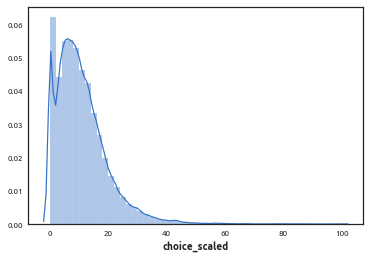

In [850]:
sns.distplot(joined_GSV_trees['choice_scaled'])

In [851]:
road_aggregated = {'osmid':[] , 'geometry' : [], 'green_gsv':[] , 'choice':[] }
for name , group in joined_GSV_trees.groupby('osmid'):
    road_aggregated['osmid'].append(name)
    road_aggregated['geometry'].append(group.iloc[0]['road_centroid'])
    road_aggregated['green_gsv'].append(np.mean(group['treePercent']))
    road_aggregated['choice'].append(group.iloc[0]['choice_scaled'])

road_aggregated_df = pd.DataFrame.from_dict(road_aggregated)
min_green = min(road_aggregated_df['green_gsv'])
max_green = max(road_aggregated_df['green_gsv'])
road_aggregated_df['green_gsv_scaled'] = road_aggregated_df['green_gsv'].apply(lambda x:((x - min_green)/(max_green-min_green))*100.0)
road_aggregated_df['green_random'] =  np.random.permutation(road_aggregated_df['green_gsv_scaled'].values)

road_aggregated_gpd = gpd.GeoDataFrame(road_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [852]:

# for k in road_aggregated.keys():
#     print(k , len(road_aggregated[k]))

In [853]:
road_aggregated_gpd.head(n=2)

osmid                   geometry  green_gsv    choice  \
0  100076118  POINT (-0.00643 51.55768)   0.030932  5.331325   
1  100076137   POINT (0.03514 51.54944)   0.083183  3.796339   

   green_gsv_scaled  green_random  
0          7.963349      0.826132  
1         21.415375      0.250298

In [854]:
road_filtered = road_aggregated_gpd[road_aggregated_gpd['choice']>0]

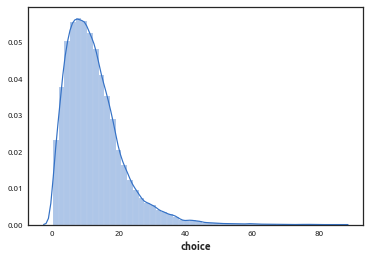

In [855]:
sns.distplot(road_filtered['choice'])

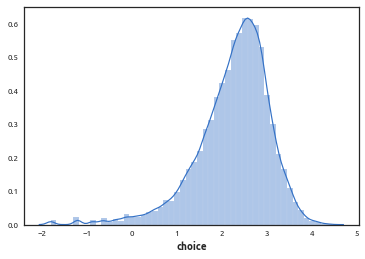

In [856]:
sns.distplot(np.log(road_filtered['choice']))

In [857]:
GSV_wards_trees_df.head(n=2)

GSS_CODE  gsv_tree_score
0  E05000026        0.041544
1  E05000027        0.044536

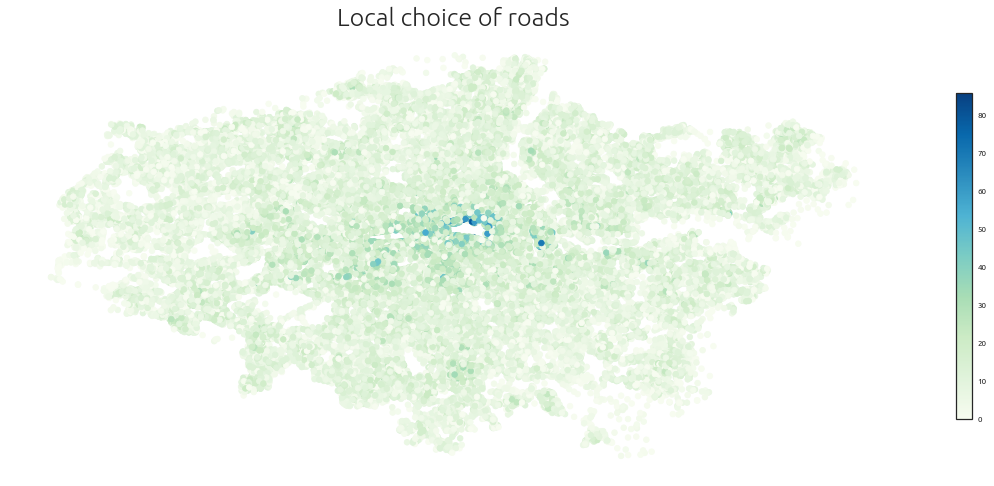

In [858]:
# road_aggregated_gpd.head(n=5)
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Local choice of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['choice'].min(), vmax=road_aggregated_gpd['choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='choice', cmap='GnBu', linewidth=0.8)

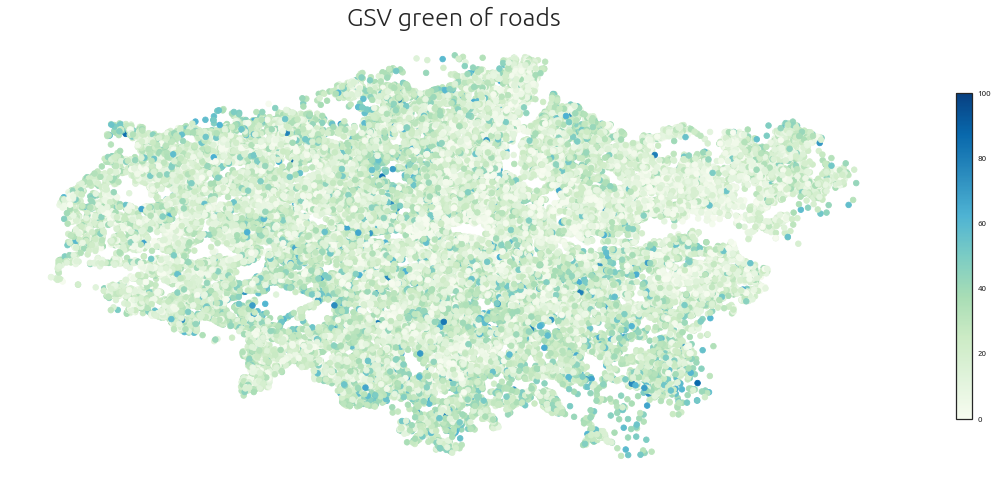

In [859]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('GSV green of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['green_gsv_scaled'].min(), vmax=road_aggregated_gpd['green_gsv_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='green_gsv_scaled', cmap='GnBu', linewidth=0.8)

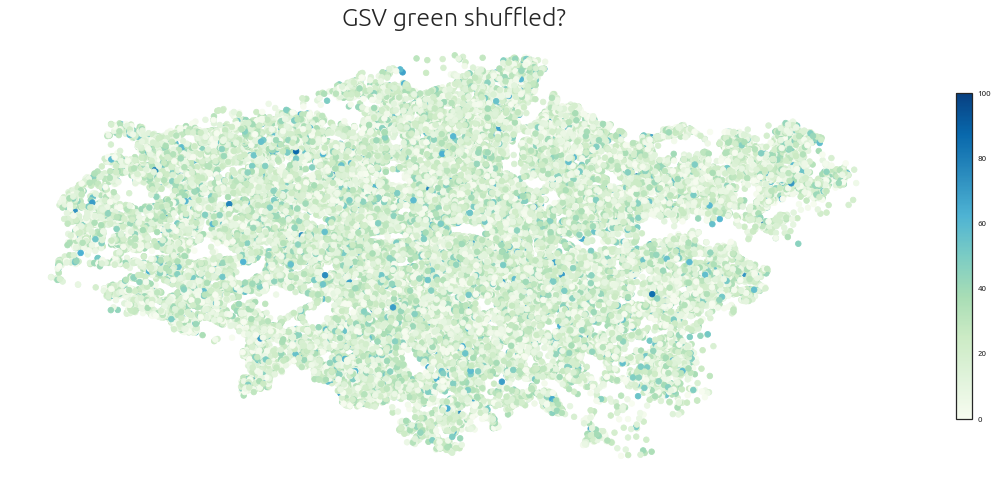

In [860]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('GSV green shuffled?', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['green_random'].min(), vmax=road_aggregated_gpd['green_random'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='green_random', cmap='GnBu', linewidth=0.8)

In [861]:
wards_shape.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  \
0       Chessington South  E05000405  Kingston upon Thames  E09000021   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames  E09000021   
2              Berrylands  E05000401  Kingston upon Thames  E09000021   
3               Alexandra  E05000400  Kingston upon Thames  E09000021   
4                Beverley  E05000402  Kingston upon Thames  E09000021   

   HECTARES  NONLD_AREA                                           geometry  
0   755.173         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...  
1   259.464         0.0  POLYGON ((-0.28409 51.36515, -0.28473 51.36541...  
2   145.390         0.0  POLYGON ((-0.30385 51.39249, -0.30375 51.39252...  
3   268.506         0.0  POLYGON ((-0.27257 51.37227, -0.27263 51.37228...  
4   187.821         0.0  POLYGON ((-0.25873 51.40956, -0.25869 51.40955...

In [862]:
wardArea = {}
for index , row in wards_shape.iterrows():
    wardArea[row['GSS_CODE']] = row['HECTARES']/100.0

In [863]:
joined_road_wards = sjoin(wards_shape,road_aggregated_gpd,how='left')

joined_road_wards= joined_road_wards[joined_road_wards['choice'].notna()]

In [864]:
joined_road_wards.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  HECTARES  \
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   

   NONLD_AREA                                           geometry  index_right  \
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...       8978.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      10440.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      10441.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      34475.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      41287.0   

                             osmid  green_gsv    choice  green_gsv_scaled  \
0                        224801816   0.010506  6.234498          2.704857   
0                         23054564   0.027564  5.852661          7.096245   
0                         23054611   0.034575  9.433333          8.901289   
0                         69146059   0.049627  3.209832         12.776371   
0  [175872776, 220771987, 2953612]   0.118918  0.926856         30.615316   

   green_random  
0      8.775328  
0     21.630215  
0      2.042610  
0      4.867898  
0     35.099821

In [865]:
sample = joined_road_wards[['NAME','GSS_CODE','osmid']]

In [866]:
sample.to_csv('scratchpad/OSMID_Ward_map.csv')

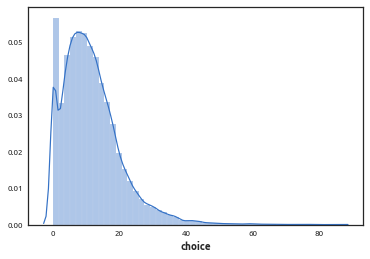

In [867]:
sns.distplot(joined_road_wards['choice'])

In [868]:
def func(x):
    if x > 0:
        x_prime = np.log(x)
        if x_prime > 0:
            return x_prime
        else:
            return 0.0
    else:
        return 0.0

0.0 85.91734965277217 10.196791731573489 11.6019420266182 8.753657286483373


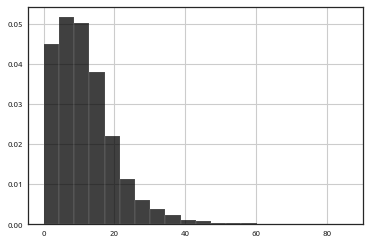

In [869]:
# the histogram of the data
data = joined_road_wards['choice']
n, bins, patches = plt.hist(data , 20, density=True, facecolor='black', alpha=0.75)
print(np.min(data), np.max(data) ,  np.median(data), np.mean(data), np.std(data))
plt.grid(True)
plt.show()

In [870]:
joined_road_wards['choice_log'] = joined_road_wards['choice'].apply(func)

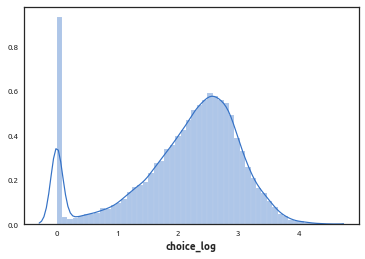

In [871]:
sns.distplot(joined_road_wards['choice_log'] )

In [872]:
gsv_ward_aggregated = {'GSS_CODE':[] , 'NAME' : [], 'geometry':[] , 'green_gsv':[] , 'green_gsv_null' : [] , 'green_gsv_unweighted'  : [] , 'mean_choice' : [] , 'median_choice': [] , 'std_choice': [] 
                       ,'green_gsv_choice_median' : [] , 'area_sqkm' : []}
for name , group in joined_road_wards.groupby('GSS_CODE'):
    gsv_ward_aggregated['GSS_CODE'].append(name)
    gsv_ward_aggregated['geometry'].append(group.iloc[0]['geometry'])
    gsv_ward_aggregated['green_gsv_choice_median'].append(np.median(group['green_gsv_scaled']*group['choice']))
    numerator = sum(group['green_gsv_scaled']*group['choice_log'])
    numerator_null = sum(group['green_gsv_scaled']*1.0)
    denom = sum(group['choice_log'])
    gsv_ward_aggregated['green_gsv'].append(numerator/denom)
    gsv_ward_aggregated['mean_choice'].append(np.mean(group['choice']))
    gsv_ward_aggregated['median_choice'].append(np.median(group['choice']))
    gsv_ward_aggregated['area_sqkm'].append(wardArea[name])
    gsv_ward_aggregated['std_choice'].append(np.std(group['choice']))
    gsv_ward_aggregated['green_gsv_null'].append(numerator_null/len(group))
    gsv_ward_aggregated['green_gsv_unweighted'].append(np.mean(group['green_gsv_scaled']))
    gsv_ward_aggregated['NAME'].append(group.iloc[0]['NAME'])
gsv_ward_aggregated_df = pd.DataFrame.from_dict(gsv_ward_aggregated)
totalGreen = sum(gsv_ward_aggregated_df['green_gsv'])
gsv_ward_aggregated_df['ward_green_contribution'] = gsv_ward_aggregated_df['green_gsv'].apply(lambda x : float(x)/float(totalGreen))
gsv_ward_aggregated_gpd = gpd.GeoDataFrame(gsv_ward_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [873]:
gsv_ward_aggregated_gpd = pd.merge(gsv_ward_aggregated_gpd , GSV_wards_trees_df,left_on='GSS_CODE', right_on='GSS_CODE')

In [874]:
gsv_ward_aggregated_gpd.head(n=5)

GSS_CODE            NAME  \
0  E05000026           Abbey   
1  E05000027          Alibon   
2  E05000028       Becontree   
3  E05000029  Chadwell Heath   
4  E05000030       Eastbrook   

                                            geometry  green_gsv  \
0  POLYGON ((0.08548 51.53704, 0.08535 51.53693, ...  10.524896   
1  POLYGON ((0.13190 51.54376, 0.13208 51.54383, ...  10.102674   
2  POLYGON ((0.10743 51.55200, 0.10757 51.55204, ...  10.891959   
3  POLYGON ((0.14698 51.57568, 0.14654 51.57566, ...  16.489458   
4  POLYGON ((0.16157 51.54333, 0.16156 51.54378, ...   9.190002   

   green_gsv_null  green_gsv_unweighted  mean_choice  median_choice  \
0       10.687261             10.687261    14.176203      13.855123   
1       10.269987             10.269987     9.614580       8.563932   
2       11.220406             11.220406    12.623284      13.285051   
3       16.415619             16.415619     8.776464       9.297543   
4        9.635628              9.635628     7.141968       7.007301   

   std_choice  green_gsv_choice_median  area_sqkm  ward_green_contribution  \
0    5.704466                68.095426    1.28292                 0.000904   
1    4.634217                70.179522    1.36442                 0.000867   
2    6.332820                89.797771    1.28809                 0.000935   
3    5.033655               108.994082    3.38422                 0.001416   
4    5.072869                38.705019    3.45060                 0.000789   

   gsv_tree_score  
0        0.041544  
1        0.044536  
2        0.042707  
3        0.067209  
4        0.041240

In [875]:
pearsonr(gsv_ward_aggregated_gpd['green_gsv'],gsv_ward_aggregated['green_gsv_unweighted'])

(0.9913237530426436, 0.0)

In [876]:
gsv_ward_aggregated_reproj = gsv_ward_aggregated_gpd.to_crs({'init': 'epsg:27700'}).copy()

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [877]:
max_sat = max(gsv_ward_aggregated_reproj['green_gsv'])
min_sat = min(gsv_ward_aggregated_reproj['green_gsv'])
gsv_ward_aggregated_reproj['green_gsv_scaled'] = gsv_ward_aggregated_reproj['green_gsv'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

max_sat = max(gsv_ward_aggregated_reproj['green_gsv_unweighted'])
min_sat = min(gsv_ward_aggregated_reproj['green_gsv_unweighted'])
gsv_ward_aggregated_reproj['green_gsv_unweighted_scaled'] = gsv_ward_aggregated_reproj['green_gsv_unweighted'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)


max_sat = max(gsv_ward_aggregated_reproj['green_gsv_null'])
min_sat = min(gsv_ward_aggregated_reproj['green_gsv_null'])
gsv_ward_aggregated_reproj['green_gsv_null_scaled'] = gsv_ward_aggregated_reproj['green_gsv_null'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

max_sat = max(gsv_ward_aggregated_reproj['gsv_tree_score'])
min_sat = min(gsv_ward_aggregated_reproj['gsv_tree_score'])
gsv_ward_aggregated_reproj['green_gsv_bland_average_scaled'] = gsv_ward_aggregated_reproj['gsv_tree_score'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

In [878]:
max_sat = max(gsv_ward_aggregated_reproj['green_gsv_choice_median'])
min_sat = min(gsv_ward_aggregated_reproj['green_gsv_choice_median'])
gsv_ward_aggregated_reproj['green_gsv_choice_median_scaled'] = gsv_ward_aggregated_reproj['green_gsv_choice_median'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

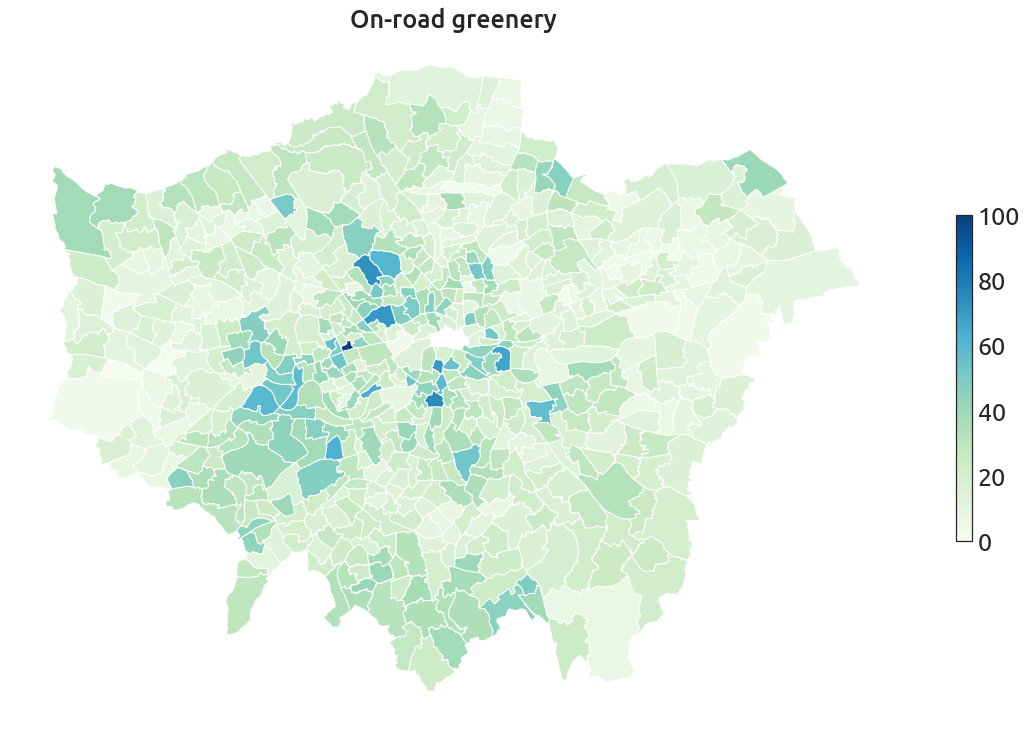

In [879]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('On-road greenery', fontdict={'fontsize': '25', 'fontweight' : '500'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_choice_median_scaled'].min(), vmax=gsv_ward_aggregated_reproj['green_gsv_choice_median_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(25)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_choice_median_scaled', cmap='GnBu', linewidth=1)

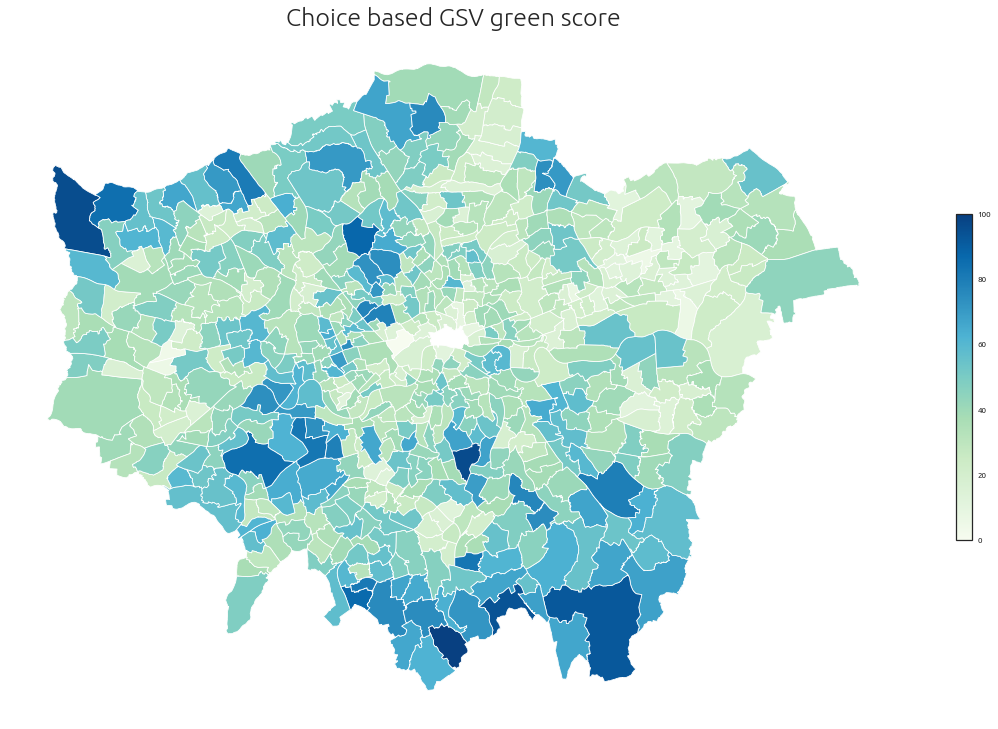

In [880]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice based GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_scaled'].min(), vmax=gsv_ward_aggregated_reproj['green_gsv_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_scaled', cmap='GnBu', linewidth=0.8)

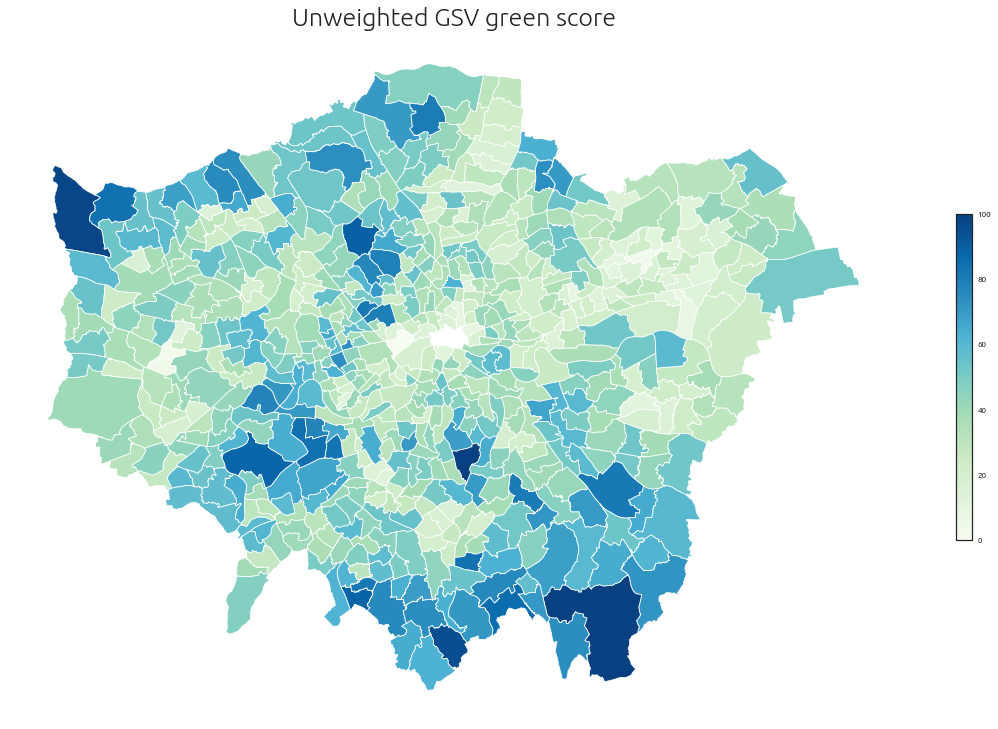

In [881]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Unweighted GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_unweighted_scaled'].min(), vmax=gsv_ward_aggregated_reproj['green_gsv_unweighted_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_unweighted_scaled', cmap='GnBu', linewidth=0.8)

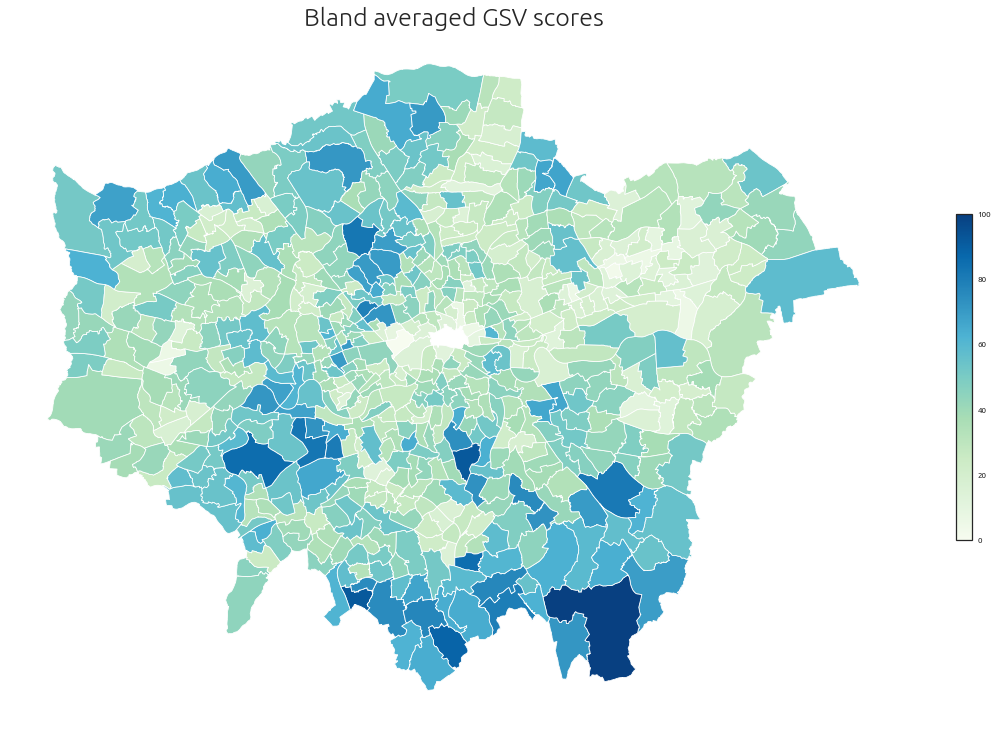

In [882]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Bland averaged GSV scores', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_bland_average_scaled'].min(), vmax=gsv_ward_aggregated_reproj['green_gsv_bland_average_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_bland_average_scaled', cmap='GnBu', linewidth=0.8)

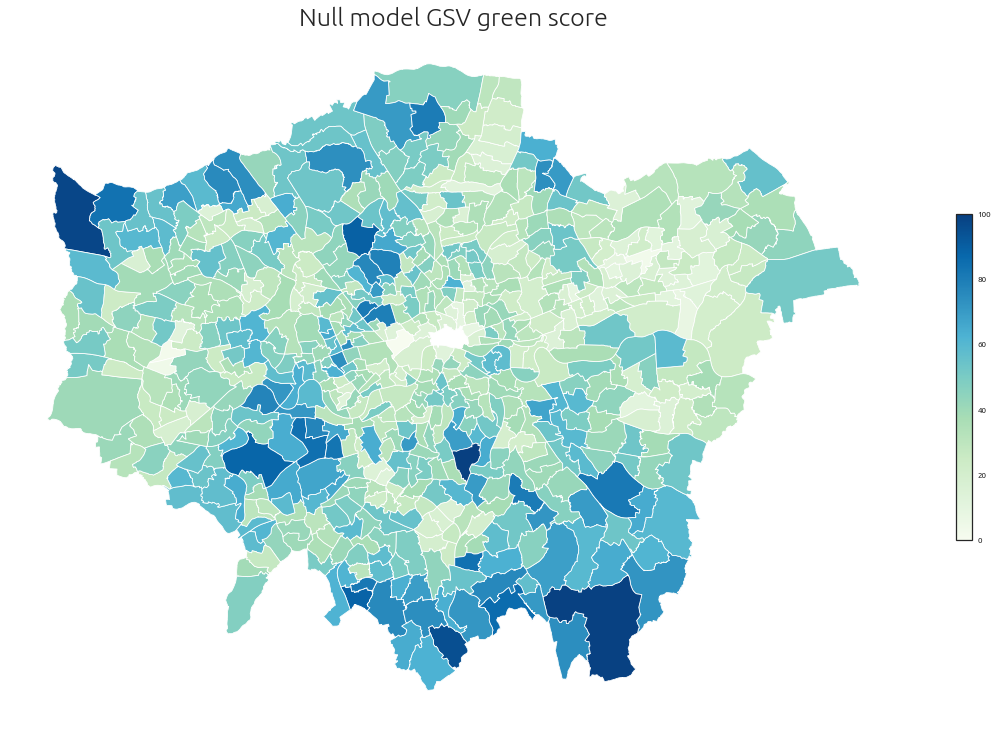

In [883]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Null model GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv_null_scaled'].min(), vmax=gsv_ward_aggregated_reproj['green_gsv_null_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv_null_scaled', cmap='GnBu', linewidth=0.8)

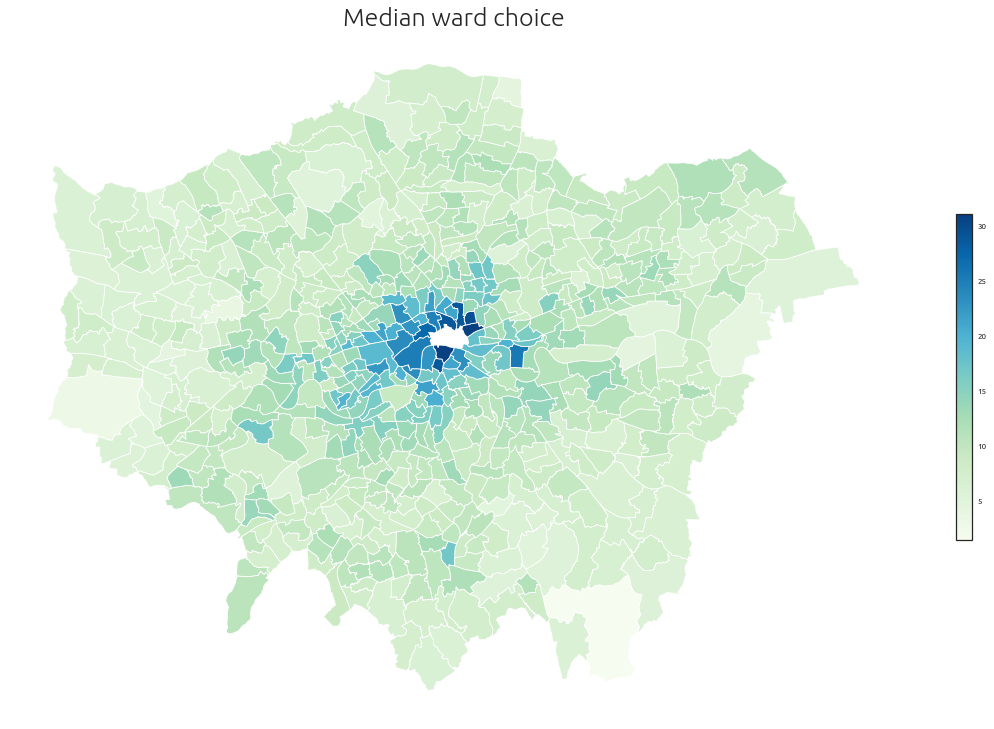

In [884]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Median ward choice', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['median_choice'].min(), vmax=gsv_ward_aggregated_gpd['median_choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='median_choice', cmap='GnBu', linewidth=0.8)

In [885]:
len(joined_road_wards)

49483

In [886]:
satellite_green = pd.read_csv('scratchpad/SAT_greenery_per_segment.csv')

In [887]:
satellite_green.head()

Unnamed: 0      osmid  sat_green_area  sat_green_pct  segment_tot_area
0           0  100076118       90.917383       0.043730       2079.067103
1           1  100076137     1870.298240       0.313623       5963.514822
2           2  100076140     7846.994381       0.393731      19929.850956
3           3  100076150       28.874368       0.046160        625.533164
4           4  100076152      793.291016       0.122778       6461.192078

In [888]:
min_sat = min(satellite_green['sat_green_pct'])
max_sat = max(satellite_green['sat_green_pct'])

satellite_green['sat_green_scaled'] = satellite_green['sat_green_pct'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)
satellite_green['sat_green_null'] = 0
satellite_green['sat_green_null'] = np.random.permutation(satellite_green['sat_green_scaled'].values)


In [889]:
len(satellite_green)

98868

In [890]:
joined_SAT_trees = pd.merge(roads_WGS84 , satellite_green,left_on='osmid' , right_on='osmid', how='inner')

In [891]:
len(joined_SAT_trees)

187202

In [892]:
joined_SAT_trees.head(n=5)

osmid                                           geometry  LogChR800  \
0  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.905958   
1  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.030195   
2  233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   3.905958   
3   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.905958   
4   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.015779   

   area  Unnamed: 0  sat_green_area  sat_green_pct  segment_tot_area  \
0  None       16731       19.649376       0.041350        475.195801   
1  None       16731       19.649376       0.041350        475.195801   
2  None       23839       47.116444       0.037721       1249.079411   
3  None       15777     1926.383081       0.230323       8363.849381   
4  None       15777     1926.383081       0.230323       8363.849381   

   sat_green_scaled  sat_green_null  
0          4.135006        4.859230  
1          4.135006        4.859230  
2          3.772093       18.692072  
3         23.032254       10.211262  
4         23.032254       10.211262

In [893]:
joined_SAT_trees = joined_SAT_trees.drop_duplicates(subset=['osmid'])
len(joined_SAT_trees)

75906

In [894]:
joined_SAT_trees.head(n=5)

osmid                                           geometry  LogChR800  \
0  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.905958   
2  233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   3.905958   
3   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.905958   
6  292570593  POLYGON ((-0.14955 51.52470, -0.14954 51.52470...   3.030195   
8  204647015  POLYGON ((-0.15274 51.52404, -0.15273 51.52403...   3.030195   

   area  Unnamed: 0  sat_green_area  sat_green_pct  segment_tot_area  \
0  None       16731       19.649376       0.041350        475.195801   
2  None       23839       47.116444       0.037721       1249.079411   
3  None       15777     1926.383081       0.230323       8363.849381   
6  None       31854     2487.382010       0.476548       5219.587666   
8  None       16729       99.786278       0.079599       1253.604707   

   sat_green_scaled  sat_green_null  
0          4.135006        4.859230  
2          3.772093       18.692072  
3         23.032254       10.211262  
6         47.654760       21.772489  
8          7.959947       33.226364

In [895]:
joined_SAT_trees = joined_SAT_trees[joined_SAT_trees['osmid'].notna()]
joined_SAT_trees = joined_SAT_trees[joined_SAT_trees['sat_green_scaled'].notna()]

joined_SAT_trees['road_centroid'] = joined_SAT_trees['geometry'].centroid

joined_SAT_trees['choice'] = joined_SAT_trees['LogChR800'].apply(lambda x : np.exp(x))
min_choice = min(joined_SAT_trees['choice'])
max_choice = max(joined_SAT_trees['choice'])

joined_SAT_trees['choice_scaled'] = joined_SAT_trees['choice'].apply(lambda x:((x - min_choice)/(max_choice-min_choice))*100.0)

In [896]:
len(joined_SAT_trees['osmid'].unique()) , len(joined_SAT_trees)

(75906, 75906)

In [897]:
joined_SAT_trees.head(n=5)

osmid                                           geometry  LogChR800  \
0  204647020  POLYGON ((-0.15275 51.52352, -0.15277 51.52352...   3.905958   
2  233623258  POLYGON ((-0.15308 51.52393, -0.15308 51.52394...   3.905958   
3   19796012  POLYGON ((-0.15806 51.52468, -0.15802 51.52466...   3.905958   
6  292570593  POLYGON ((-0.14955 51.52470, -0.14954 51.52470...   3.030195   
8  204647015  POLYGON ((-0.15274 51.52404, -0.15273 51.52403...   3.030195   

   area  Unnamed: 0  sat_green_area  sat_green_pct  segment_tot_area  \
0  None       16731       19.649376       0.041350        475.195801   
2  None       23839       47.116444       0.037721       1249.079411   
3  None       15777     1926.383081       0.230323       8363.849381   
6  None       31854     2487.382010       0.476548       5219.587666   
8  None       16729       99.786278       0.079599       1253.604707   

   sat_green_scaled  sat_green_null              road_centroid     choice  \
0          4.135006        4.859230  POINT (-0.15273 51.52362)  49.697653   
2          3.772093       18.692072  POINT (-0.15287 51.52381)  49.697653   
3         23.032254       10.211262  POINT (-0.15563 51.52397)  49.697653   
6         47.654760       21.772489  POINT (-0.15122 51.52432)  20.701265   
8          7.959947       33.226364  POINT (-0.15278 51.52383)  20.701265   

   choice_scaled  
0      35.194399  
2      35.194399  
3      35.194399  
6      14.086097  
8      14.086097

In [898]:
road_SAT_aggregated = joined_SAT_trees[['road_centroid','sat_green_scaled','sat_green_null','choice_scaled','osmid']].copy()
road_SAT_aggregated_gpd = gpd.GeoDataFrame(road_SAT_aggregated, geometry='road_centroid', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

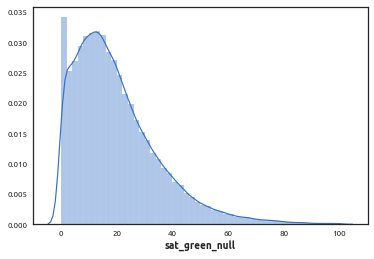

In [899]:
sns.distplot(road_SAT_aggregated_gpd['sat_green_null'])

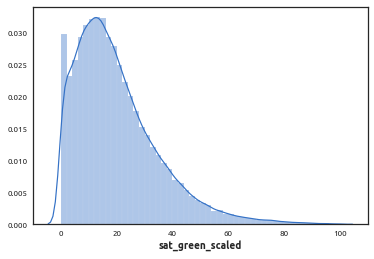

In [900]:
sns.distplot(road_SAT_aggregated_gpd['sat_green_scaled'])

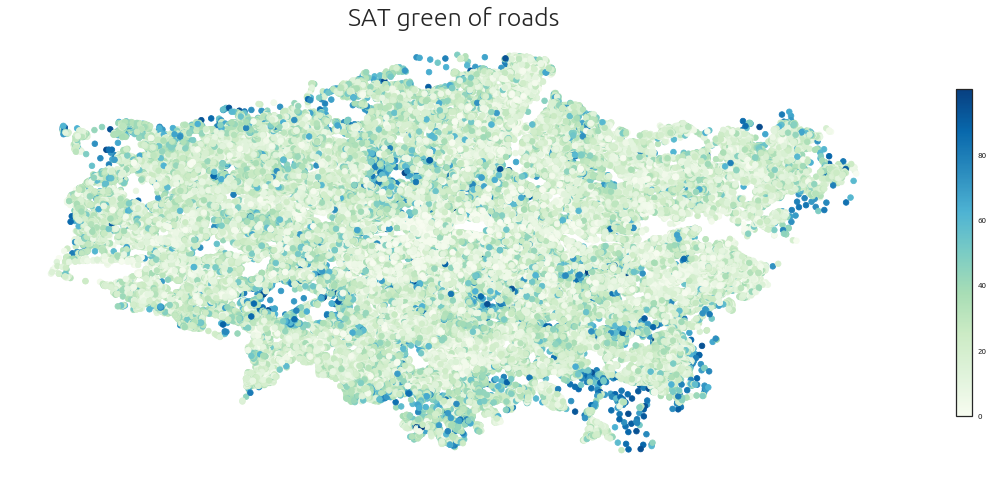

In [901]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('SAT green of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_SAT_aggregated_gpd['sat_green_scaled'].min(), vmax=road_SAT_aggregated_gpd['sat_green_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_SAT_aggregated_gpd.plot(ax=ax,column='sat_green_scaled', cmap='GnBu', linewidth=0.8)

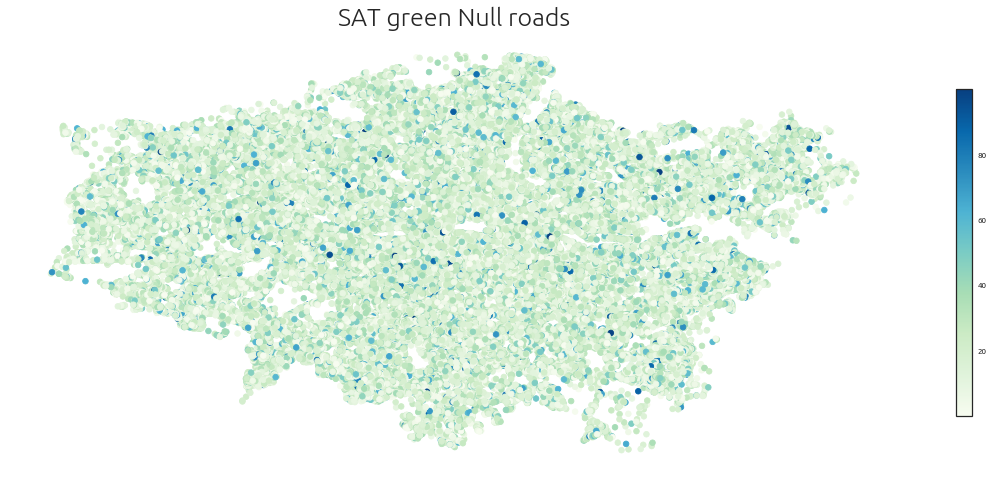

In [902]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('SAT green Null roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_SAT_aggregated_gpd['sat_green_null'].min(), vmax=road_SAT_aggregated_gpd['sat_green_null'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_SAT_aggregated_gpd.plot(ax=ax,column='sat_green_null', cmap='GnBu', linewidth=0.8)

In [903]:
joined_sat_road_wards = sjoin(wards_shape,road_SAT_aggregated_gpd,how='left')

joined_sat_road_wards= joined_sat_road_wards[joined_sat_road_wards['choice_scaled'].notna()]

joined_sat_road_wards.head(n=5)

NAME   GSS_CODE              DISTRICT  LAGSSCODE  HECTARES  \
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   
0  Chessington South  E05000405  Kingston upon Thames  E09000021   755.173   

   NONLD_AREA                                           geometry  index_right  \
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     160179.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     162429.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      24605.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...      24611.0   
0         0.0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     159164.0   

   sat_green_scaled  sat_green_null  choice_scaled      osmid  
0         13.028177       17.151251       5.702095  161636078  
0         15.944775        8.395446      15.114575  161415777  
0         14.326146       27.704904      19.890688  154532354  
0         17.393054        4.705427      19.890688  154532353  
0          6.817382        3.973039       0.000000   19822697

In [904]:
joined_sat_road_wards['choice_log'] = joined_sat_road_wards['choice_scaled'].apply(func)

In [905]:
sat_ward_aggregated = {'GSS_CODE':[] , 'NAME' : [], 'geometry':[] , 'green_sat':[] ,'green_sat_choice_median':[] ,'green_sat_null': [] , 'green_sat_unweighted' : [] , 'ward_choice':[]}
for name , group in joined_sat_road_wards.groupby('GSS_CODE'):
    sat_ward_aggregated['GSS_CODE'].append(name)
    sat_ward_aggregated['geometry'].append(group.iloc[0]['geometry'])
    sat_ward_aggregated['green_sat_choice_median'].append(np.median(group['sat_green_scaled']*group['choice_log']))
    numerator = sum(group['sat_green_scaled']*group['choice_log'])
    numerator_null = sum(group['sat_green_null']*group['choice_log'])
    denom = sum(group['choice_log'])
    sat_ward_aggregated['green_sat'].append(numerator/len(group))
    sat_ward_aggregated['green_sat_null'].append(numerator_null/denom)
    sat_ward_aggregated['green_sat_unweighted'].append(np.mean(group['sat_green_scaled']))
    sat_ward_aggregated['ward_choice'].append(np.mean(group['choice_log']))
    sat_ward_aggregated['NAME'].append(group.iloc[0]['NAME'])
sat_ward_aggregated_df = pd.DataFrame.from_dict(sat_ward_aggregated)
totalGreen = sum(sat_ward_aggregated_df['green_sat'])
sat_ward_aggregated_df['ward_sat_green_contribution'] = sat_ward_aggregated_df['green_sat'].apply(lambda x : float(x)/float(totalGreen))
sat_ward_aggregated_gpd = gpd.GeoDataFrame(sat_ward_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [906]:
sat_ward_aggregated_reproj = sat_ward_aggregated_gpd.to_crs({'init': 'epsg:27700'}).copy()

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [907]:
max_sat = max(sat_ward_aggregated_reproj['green_sat'])
min_sat = min(sat_ward_aggregated_reproj['green_sat'])
sat_ward_aggregated_reproj['green_sat_scaled'] = sat_ward_aggregated_reproj['green_sat'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

max_sat = max(sat_ward_aggregated_reproj['green_sat_unweighted'])
min_sat = min(sat_ward_aggregated_reproj['green_sat_unweighted'])
sat_ward_aggregated_reproj['green_sat_unweighted_scaled'] = sat_ward_aggregated_reproj['green_sat_unweighted'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)


max_sat = max(sat_ward_aggregated_reproj['green_sat_null'])
min_sat = min(sat_ward_aggregated_reproj['green_sat_null'])
sat_ward_aggregated_reproj['green_sat_null_scaled'] = sat_ward_aggregated_reproj['green_sat_null'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)


max_sat = max(sat_ward_aggregated_reproj['green_sat_choice_median'])
min_sat = min(sat_ward_aggregated_reproj['green_sat_choice_median'])
sat_ward_aggregated_reproj['green_sat_choice_median_scaled'] = sat_ward_aggregated_reproj['green_sat_choice_median'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

In [908]:
sat_ward_aggregated_reproj

GSS_CODE            NAME  \
0    E05000026           Abbey   
1    E05000027          Alibon   
2    E05000028       Becontree   
3    E05000029  Chadwell Heath   
4    E05000030       Eastbrook   
..         ...             ...   
627  E05011485   South Norwood   
628  E05011486  Thornton Heath   
629  E05011487          Waddon   
630  E05011488   West Thornton   
631  E05011489        Woodside   

                                              geometry  green_sat  \
0    POLYGON ((544735.197 184076.498, 544726.597 18...  30.625831   
1    POLYGON ((547932.401 184916.597, 547944.801 18...  39.401517   
2    POLYGON ((546209.397 185783.599, 546219.300 18...  46.012295   
3    POLYGON ((548874.201 188496.302, 548843.200 18...  35.306934   
4    POLYGON ((549991.498 184928.504, 549988.900 18...  24.041618   
..                                                 ...        ...   
627  POLYGON ((533192.804 166825.795, 533214.604 16...  30.136153   
628  POLYGON ((531555.599 169063.195, 531581.002 16...  21.881059   
629  POLYGON ((531218.598 162415.198, 531223.100 16...  35.209853   
630  POLYGON ((530025.703 167330.601, 530020.203 16...  18.582627   
631  POLYGON ((535516.501 168006.797, 535511.703 16...  21.340343   

     green_sat_choice_median  green_sat_null  green_sat_unweighted  \
0                  22.024216       20.708883             12.963320   
1                  37.485762       21.940593             21.693588   
2                  48.181680       22.554598             21.635097   
3                  27.296836       21.747151             20.210907   
4                  20.751639       23.563254             15.853971   
..                       ...             ...                   ...   
627                26.112574       22.747765             15.304899   
628                16.595109       20.863686             11.984060   
629                27.190920       20.731828             16.576264   
630                15.954824       19.197902              9.271327   
631                14.865777       19.439357             10.715035   

     ward_choice  ward_sat_green_contribution  green_sat_scaled  \
0       2.459929                     0.001206         21.114984   
1       2.035775                     0.001551         32.604364   
2       2.319015                     0.001812         41.259383   
3       1.766450                     0.001390         27.243619   
4       1.640392                     0.000947         12.494744   
..           ...                          ...               ...   
627     2.090771                     0.001186         20.473883   
628     2.092941                     0.000861          9.666078   
629     2.126077                     0.001386         27.116517   
630     2.154600                     0.000732          5.347677   
631     2.073687                     0.000840          8.958157   

     green_sat_unweighted_scaled  green_sat_null_scaled  \
0                      16.018420              51.592689   
1                      35.402366              62.560068   
2                      35.272496              68.027282   
3                      32.110345              60.837620   
4                      22.436576              77.008546   
..                           ...                    ...   
627                    21.217463              69.747284   
628                    13.844155              52.971087   
629                    24.040294              51.796996   
630                     7.821034              38.138631   
631                    11.026520              40.288592   

     green_sat_choice_median_scaled  
0                         20.624945  
1                         39.367628  
2                         52.333357  
3                         27.016483  
4                         19.082311  
..                              ...  
627                       25.580904  
628                       14.043712  
629                       26.888090  
630                       13.2675

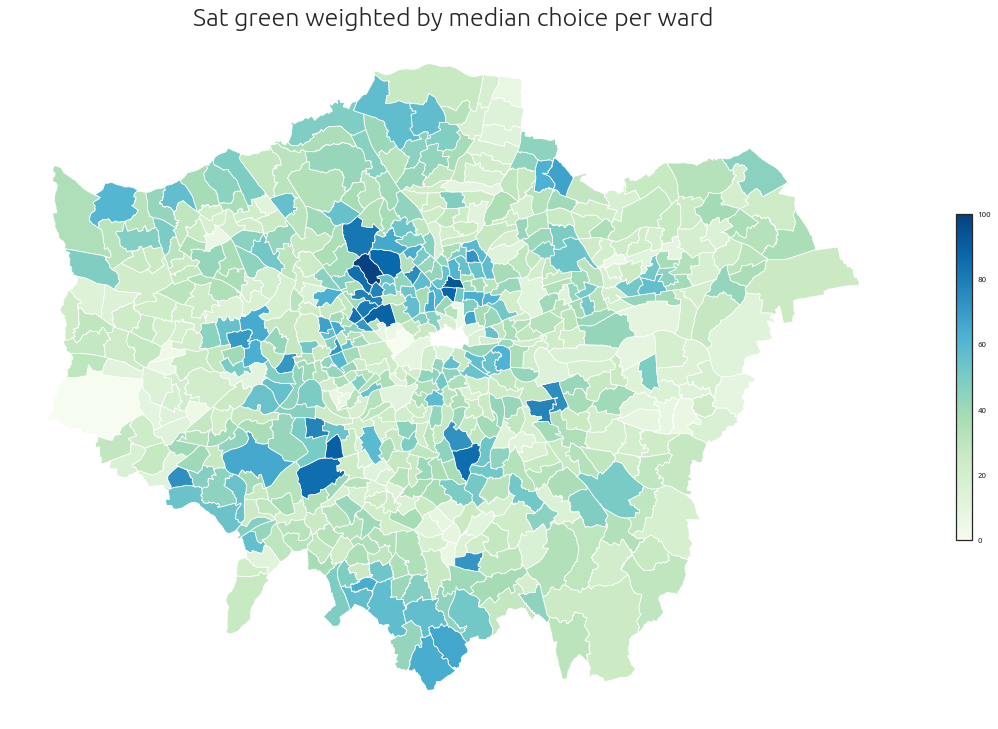

In [909]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Sat green weighted by median choice per ward', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_choice_median_scaled'].min(), vmax=sat_ward_aggregated_reproj['green_sat_choice_median_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_choice_median_scaled', cmap='GnBu', linewidth=0.8)

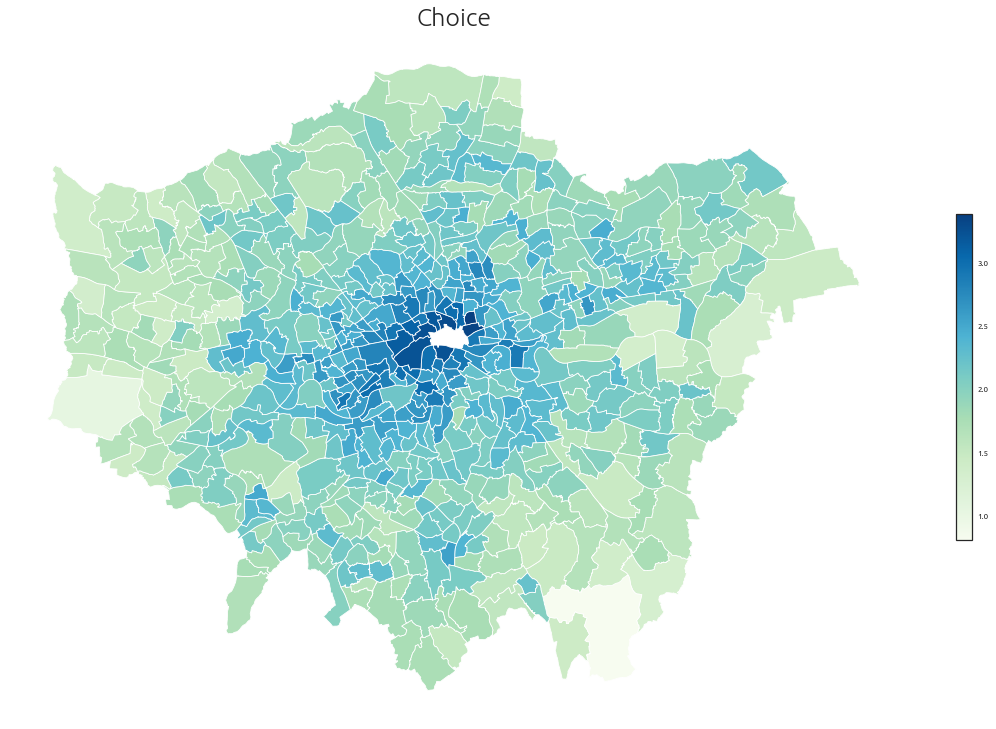

In [910]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['ward_choice'].min(), vmax=sat_ward_aggregated_reproj['ward_choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='ward_choice', cmap='GnBu', linewidth=0.8)

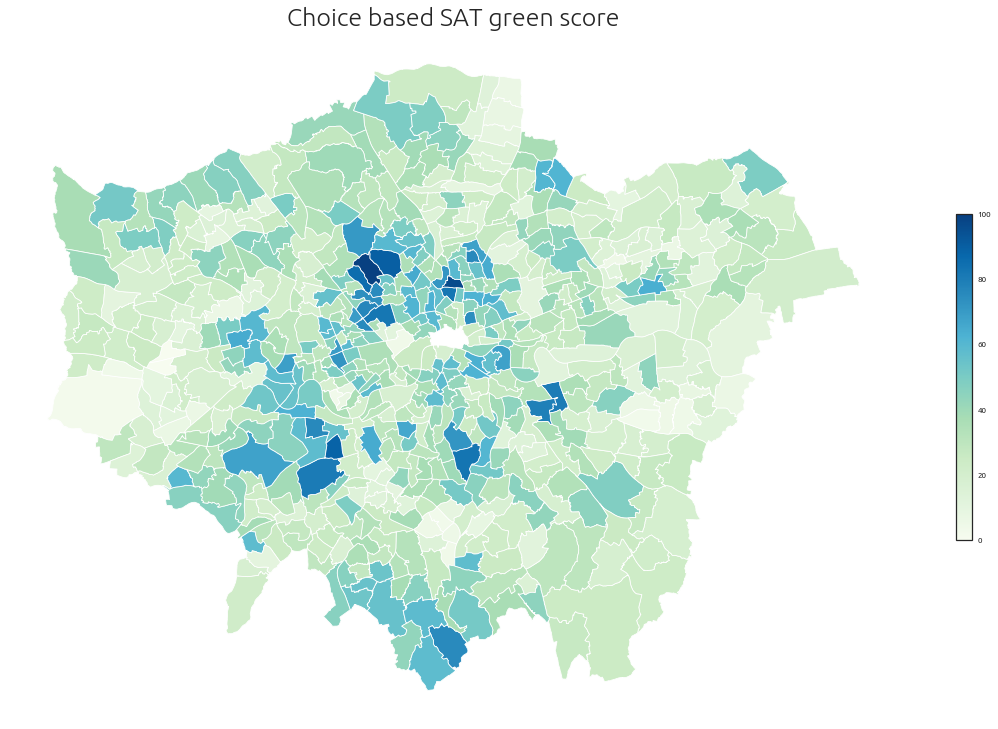

In [911]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice based SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_scaled'].min(), vmax=sat_ward_aggregated_reproj['green_sat_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_scaled', cmap='GnBu', linewidth=0.8)

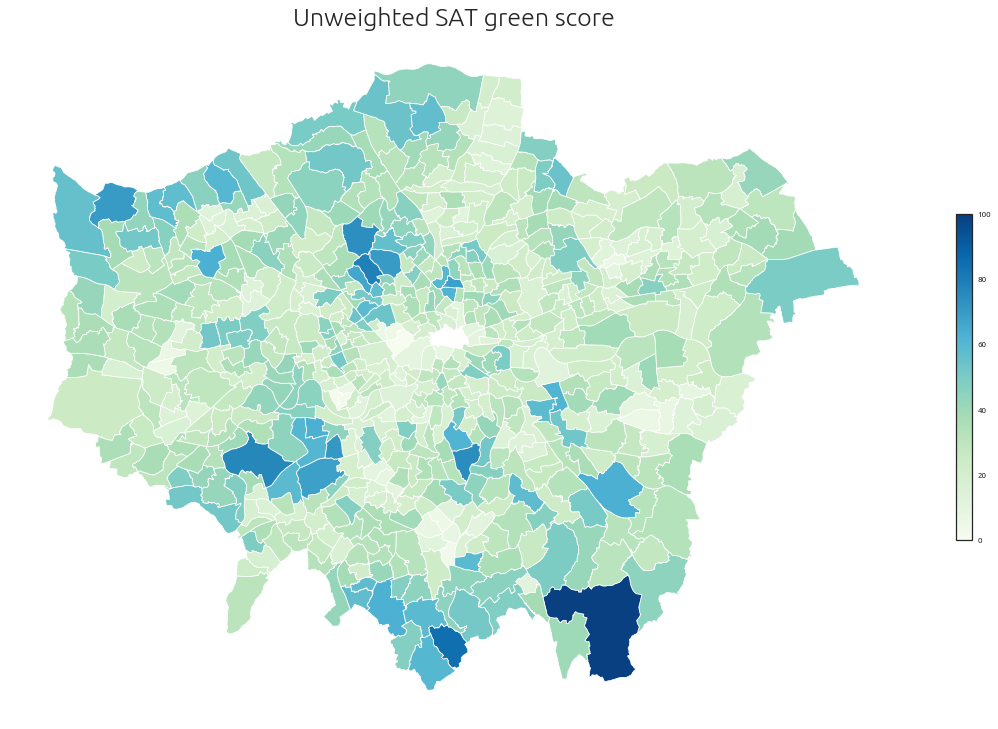

In [912]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Unweighted SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_unweighted_scaled'].min(), vmax=sat_ward_aggregated_reproj['green_sat_unweighted_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_unweighted_scaled', cmap='GnBu', linewidth=0.8)

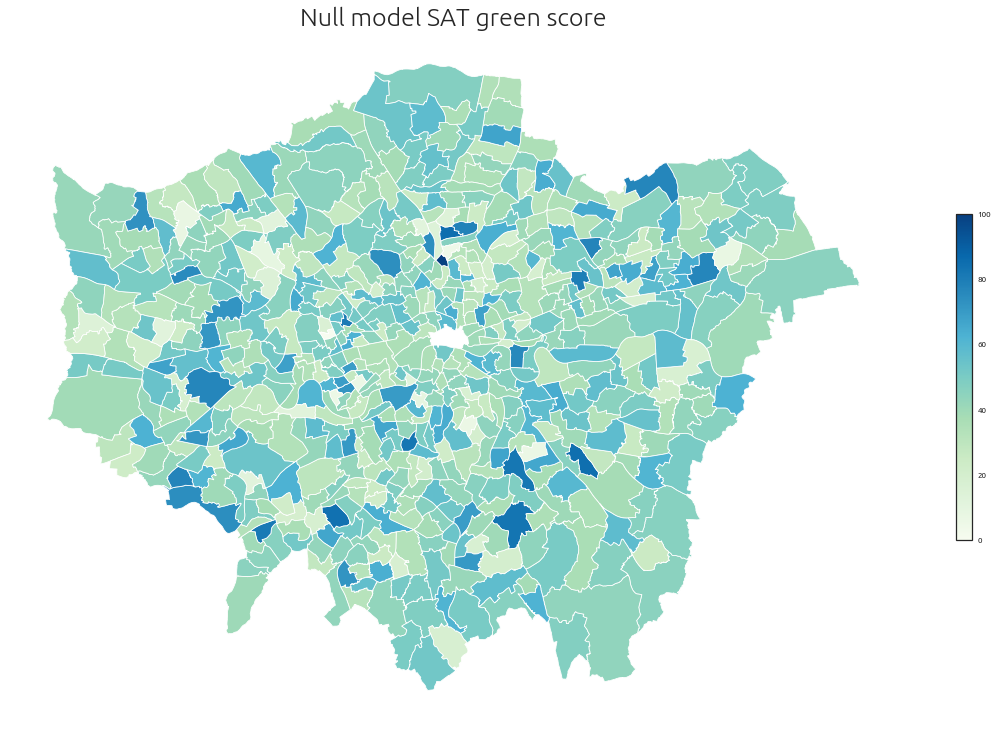

In [913]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Null model SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_null_scaled'].min(), vmax=sat_ward_aggregated_reproj['green_sat_null_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_null_scaled', cmap='GnBu', linewidth=0.8)

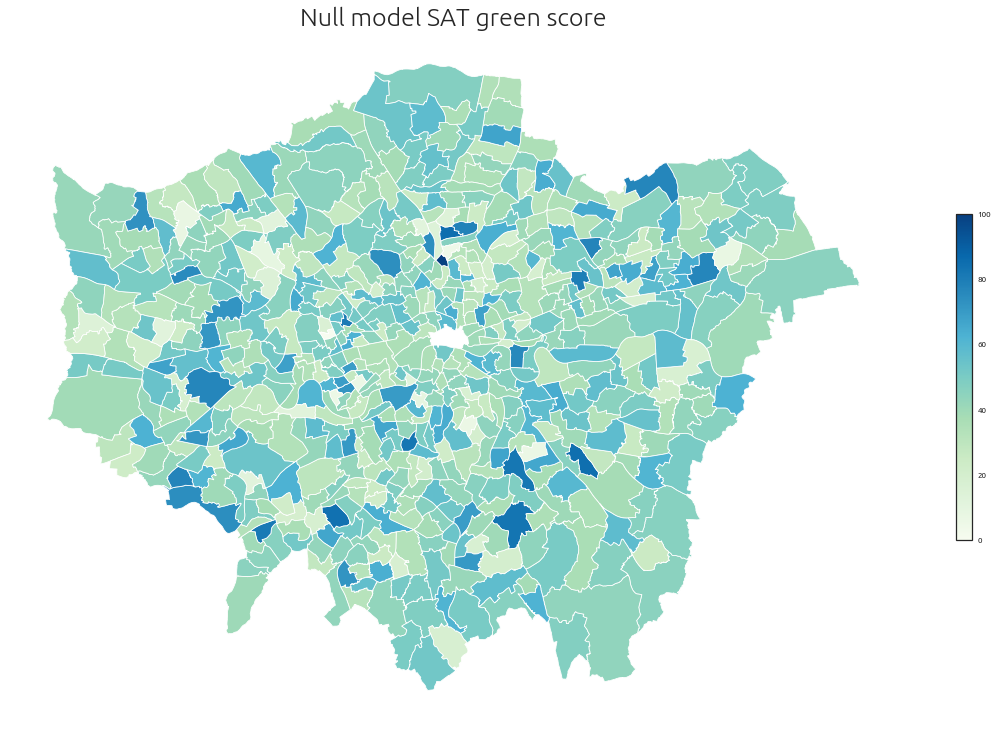

In [914]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Null model SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat_null_scaled'].min(), vmax=sat_ward_aggregated_reproj['green_sat_null_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat_null_scaled', cmap='GnBu', linewidth=0.8)

In [915]:
# sat_ward_aggregated_reproj.to_file("Choice_Green_scores/London_choice_sat_green_score.shp")
# gsv_ward_aggregated_reproj.to_file("Choice_Green_scores/London_choice_gsv_green_score.shp")

In [916]:
sat_ward_aggregated_reproj.head(n=2)

GSS_CODE    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_sat  green_sat_choice_median  green_sat_null  green_sat_unweighted  \
0  30.625831                22.024216       20.708883             12.963320   
1  39.401517                37.485762       21.940593             21.693588   

   ward_choice  ward_sat_green_contribution  green_sat_scaled  \
0     2.459929                     0.001206         21.114984   
1     2.035775                     0.001551         32.604364   

   green_sat_unweighted_scaled  green_sat_null_scaled  \
0                    16.018420              51.592689   
1                    35.402366              62.560068   

   green_sat_choice_median_scaled  
0                       20.624945  
1                       39.367628

In [917]:
gsv_ward_aggregated_reproj.head(n=2)

GSS_CODE    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_gsv  green_gsv_null  green_gsv_unweighted  mean_choice  \
0  10.524896       10.687261             10.687261    14.176203   
1  10.102674       10.269987             10.269987     9.614580   

   median_choice  std_choice  green_gsv_choice_median  area_sqkm  \
0      13.855123    5.704466                68.095426    1.28292   
1       8.563932    4.634217                70.179522    1.36442   

   ward_green_contribution  gsv_tree_score  green_gsv_scaled  \
0                 0.000904        0.041544         15.342713   
1                 0.000867        0.044536         14.007817   

   green_gsv_unweighted_scaled  green_gsv_null_scaled  \
0                    15.473889              15.473889   
1                    14.117661              14.117661   

   green_gsv_bland_average_scaled  green_gsv_choice_median_scaled  
0                       13.878948                        9.589707  
1                       16.235844                        9.987546

In [918]:
green_sat_sub = sat_ward_aggregated_reproj[['GSS_CODE','green_sat','green_sat_choice_median','green_sat_null','green_sat_unweighted','ward_sat_green_contribution']].copy()
overall_green = pd.merge(gsv_ward_aggregated_reproj,green_sat_sub, left_on='GSS_CODE' , right_on='GSS_CODE')

In [919]:
overall_green.columns

Index(['GSS_CODE', 'NAME', 'geometry', 'green_gsv', 'green_gsv_null',
       'green_gsv_unweighted', 'mean_choice', 'median_choice', 'std_choice',
       'green_gsv_choice_median', 'area_sqkm', 'ward_green_contribution',
       'gsv_tree_score', 'green_gsv_scaled', 'green_gsv_unweighted_scaled',
       'green_gsv_null_scaled', 'green_gsv_bland_average_scaled',
       'green_gsv_choice_median_scaled', 'green_sat',
       'green_sat_choice_median', 'green_sat_null', 'green_sat_unweighted',
       'ward_sat_green_contribution'],
      dtype='object')

In [920]:
overall_green.head(n=2)

GSS_CODE    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_gsv  green_gsv_null  green_gsv_unweighted  mean_choice  \
0  10.524896       10.687261             10.687261    14.176203   
1  10.102674       10.269987             10.269987     9.614580   

   median_choice  std_choice  green_gsv_choice_median  ...  green_gsv_scaled  \
0      13.855123    5.704466                68.095426  ...         15.342713   
1       8.563932    4.634217                70.179522  ...         14.007817   

   green_gsv_unweighted_scaled  green_gsv_null_scaled  \
0                    15.473889              15.473889   
1                    14.117661              14.117661   

   green_gsv_bland_average_scaled  green_gsv_choice_median_scaled  green_sat  \
0                       13.878948                        9.589707  30.625831   
1                       16.235844                        9.987546  39.401517   

   green_sat_choice_median  green_sat_null  green_sat_unweighted  \
0                22.024216       20.708883             12.963320   
1                37.485762       21.940593             21.693588   

   ward_sat_green_contribution  
0                     0.001206  
1                     0.001551  

[2 rows x 23 columns]

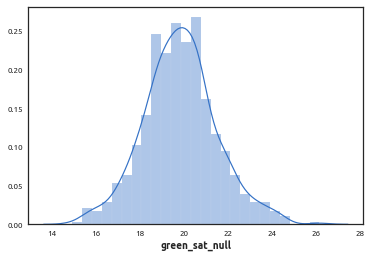

In [921]:
sns.distplot(overall_green['green_sat_null'])

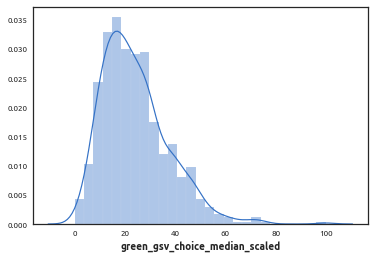

In [922]:
sns.distplot(overall_green['green_gsv_choice_median_scaled'])

In [923]:
overall_green.to_file("Choice_Green_scores/London_choice_green_scores.shp")

In [924]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [925]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , 'Prescriptions' : [] , 'Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data['Prescriptions'].append(dictionary1[k])
            data['Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe

In [926]:
depression = getDiseaase_frame(diseases, '201610' , 'depression')

In [927]:
data = pd.read_csv('Solo_living/All_data_aggregated_ward_level.csv')

In [928]:
list(data.columns)

['Unnamed: 0',
 'Unnamed: 0.1',
 'green_score',
 'GSS_CODE',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0.1.1',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'gastroparesis_Prescriptions',
 'gastroparesis_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkinson_Prescriptions',
 'parkinson_Prevalence',
 'sleep apnea_Prescriptions',
 'sleep apnea_Prevalence',
 'interstitial cystitis_Prescriptions',
 'interstitial cystitis_Prevalence',
 'bipolar_Prescriptions',
 'bipolar_Prevalence',
 'hypothyroid

In [929]:
ward_data = pd.read_csv('scratchpad/london_ward_imd_measures.csv')

In [930]:
# ward_sat_green_all = pd.read_csv('scratchpad/london_sat_ward_green_all.csv')
ward_sat_green_all = pd.read_csv('scratchpad/complementary_satellite_green.csv')

# ward_sat_green_all = ward_sat_green_all.rename(columns={"percent_green": "sat_all_ward_green"})
ward_sat_green_all = ward_sat_green_all.rename(columns={"percent_off_road_sat_green": "sat_all_ward_green"})

In [931]:
ward_sat_green_all.head(n=2)

ward_code  ward_area  percent_on_road_sat_green_area  \
0  E05000026  1282920.0                        0.036192   
1  E05000027  1364420.0                        0.043492   

   percent_tot_sat_green  sat_all_ward_green  
0                 0.2784            0.242208  
1                 0.4594            0.415908

In [932]:
selected_aggregate_data= data[['GSS_CODE',
                          'Median 2012/13','depression_Prevalence',
                          'diabetes_Prevalence','Population_per_square_kilometre','depression_Prescriptions']].copy()

In [933]:
len(selected_aggregate_data)

424

In [934]:
ward_data.head(n=2)


Ward Code Ward Name               Borough  Population  \
0  E05000026     Abbey  Barking and Dagenham       14370   
1  E05000027    Alibon  Barking and Dagenham       10845   

   Working age population  Child population  16-59 population  \
0                    9403              3899              9397   
1                    6459              2865              6600   

   Old age population IMD Extent %  IMD Extent Rank  ...  Income rank  \
0                1074          43%               82  ...          111   
1                1380          65%               25  ...           58   

   Employment scale  Employment score  Employment rank  IDACI scale  \
0             870.6             0.093              252       915.40   
1             883.2             0.137               40       737.44   

  IDACI score IDACI score rank  IDAOPI scale  IDAOPI score  \
0       0.235              154        376.91         0.351   
1       0.257              112        379.34         0.275   

   IDAOPI score (rank)  
0                   99  
1                  199  

[2 rows x 34 columns]

In [935]:
print(ward_data.columns)

Index(['Ward Code', 'Ward Name', 'Borough', 'Population',
       'Working age population', 'Child population', '16-59 population',
       'Old age population', 'IMD Extent %', 'IMD Extent Rank',
       'IMD Average rank', 'IMD average rank rank', 'IMD average score',
       'IMD average score rank', 'Rank of worst LSOA', 'Worst LSOA Code',
       'Worst LSOA: % of resident in ward', 'Number of LSOAs',
       '# LSOAs in worst 5%', '# LSOAs in worst 10%', '# LSOAs in worst 20%',
       '# LSOAs in worst 50%', 'Income scale', 'Income score', 'Income rank',
       'Employment scale', 'Employment score', 'Employment rank',
       'IDACI scale', 'IDACI score', 'IDACI score rank', 'IDAOPI scale',
       'IDAOPI score', 'IDAOPI score (rank)'],
      dtype='object')


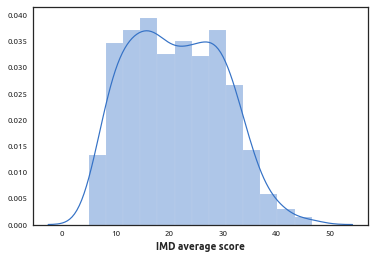

In [936]:
sns.distplot(ward_data['IMD average score'])

In [937]:
selected_ward_data= ward_data[['Ward Code',
                          'Population','Working age population',
                          'IMD average score' , 'Income score','Employment score','IDACI score','IDAOPI score']].copy()

In [938]:
print(len(selected_ward_data))

633


In [939]:
selected_ward_data = pd.merge(selected_ward_data,selected_aggregate_data, left_on='Ward Code' , right_on='GSS_CODE')

In [940]:
overall_green = pd.merge(overall_green,ward_sat_green_all, left_on='GSS_CODE' , right_on='ward_code')
print(len(overall_green))

632


In [941]:
overall_green.to_file("Choice_Green_scores/London_choice_green_scores_V2.shp")

In [942]:
overall_green.columns

Index(['GSS_CODE', 'NAME', 'geometry', 'green_gsv', 'green_gsv_null',
       'green_gsv_unweighted', 'mean_choice', 'median_choice', 'std_choice',
       'green_gsv_choice_median', 'area_sqkm', 'ward_green_contribution',
       'gsv_tree_score', 'green_gsv_scaled', 'green_gsv_unweighted_scaled',
       'green_gsv_null_scaled', 'green_gsv_bland_average_scaled',
       'green_gsv_choice_median_scaled', 'green_sat',
       'green_sat_choice_median', 'green_sat_null', 'green_sat_unweighted',
       'ward_sat_green_contribution', 'ward_code', 'ward_area',
       'percent_on_road_sat_green_area', 'percent_tot_sat_green',
       'sat_all_ward_green'],
      dtype='object')

In [943]:
Vitamin_N = overall_green[['GSS_CODE' , 'NAME' , 'green_gsv' , 'sat_all_ward_green' , 'mean_choice' , 'median_choice', 'std_choice']].copy()

In [944]:
Vitamin_N.rename(columns={'GSS_CODE':'Ward_code' , 'NAME':'Ward_name' , 'green_gsv': 'Routine_green' , 'sat_all_ward_green' :'Off_road_green'} , inplace=True)
Vitamin_N.head(n=4)

Ward_code       Ward_name  Routine_green  Off_road_green  mean_choice  \
0  E05000026           Abbey      10.524896        0.242208    14.176203   
1  E05000027          Alibon      10.102674        0.415908     9.614580   
2  E05000028       Becontree      10.891959        0.301455    12.623284   
3  E05000029  Chadwell Heath      16.489458        0.597515     8.776464   

   median_choice  std_choice  
0      13.855123    5.704466  
1       8.563932    4.634217  
2      13.285051    6.332820  
3       9.297543    5.033655

In [945]:
Vitamin_N['Off_road_green'] = Vitamin_N['Off_road_green']*100

In [946]:
Vitamin_N.describe()

Routine_green  Off_road_green  mean_choice  median_choice  std_choice
count     632.000000      632.000000   632.000000     632.000000  632.000000
mean       18.430472       36.921615    11.273718      10.854646    6.665204
std         5.439316       15.978908     4.187648       4.214202    2.229202
min         5.672061        3.926468     1.804909       1.476778    0.000000
25%        14.589412       25.222712     8.506605       8.146343    5.236842
50%        18.025715       35.762529    10.254552      10.007512    6.094366
75%        21.900599       44.749906    12.808061      12.431628    7.536051
max        37.301639       88.936597    33.327638      31.066684   18.620241

In [947]:
Vitamin_N.to_csv('scratchpad/Vitamin_N.csv')

In [948]:
Vitamin_N_shp = overall_green[['GSS_CODE' , 'NAME' , 'geometry' ,'green_gsv' , 'sat_all_ward_green' , 'mean_choice' , 'median_choice', 'std_choice']].copy()

In [949]:
Vitamin_N_shp.rename(columns={'GSS_CODE':'Ward_code' , 'NAME':'Ward_name' , 'green_gsv': 'Routine_green' , 'sat_all_ward_green' :'Off_road_green'} , inplace=True)
Vitamin_N_shp['Off_road_green'] = Vitamin_N_shp['Off_road_green']*100

In [950]:
Vitamin_N_shp.to_file("Choice_Green_scores/London_Vitamin_N.shp")

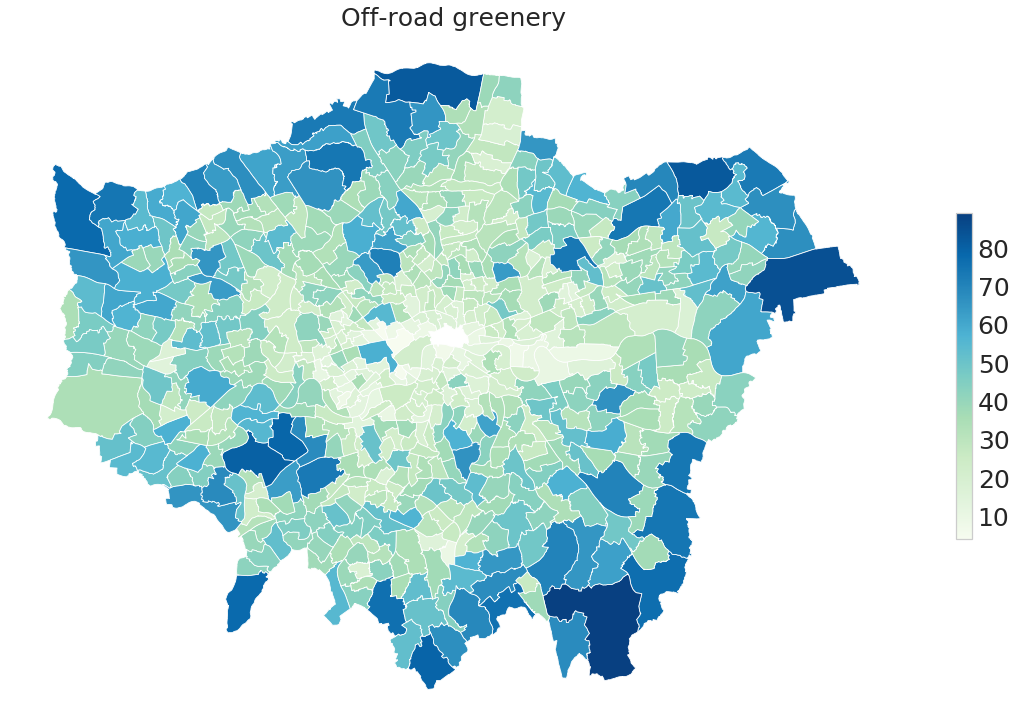

In [817]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Off-road greenery', fontdict={'fontsize': '25', 'fontweight' : '500'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=Vitamin_N_shp['Off_road_green'].min(), vmax=Vitamin_N_shp['Off_road_green'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(25)
Vitamin_N_shp.plot(ax=ax,column='Off_road_green', cmap='GnBu', linewidth=0.8)

In [663]:
overall_green

GSS_CODE            NAME  \
0    E05000026           Abbey   
1    E05000027          Alibon   
2    E05000028       Becontree   
3    E05000029  Chadwell Heath   
4    E05000030       Eastbrook   
..         ...             ...   
627  E05011485   South Norwood   
628  E05011486  Thornton Heath   
629  E05011487          Waddon   
630  E05011488   West Thornton   
631  E05011489        Woodside   

                                              geometry  green_gsv  \
0    POLYGON ((544735.197 184076.498, 544726.597 18...  10.524896   
1    POLYGON ((547932.401 184916.597, 547944.801 18...  10.102674   
2    POLYGON ((546209.397 185783.599, 546219.300 18...  10.891959   
3    POLYGON ((548874.201 188496.302, 548843.200 18...  16.489458   
4    POLYGON ((549991.498 184928.504, 549988.900 18...   9.190002   
..                                                 ...        ...   
627  POLYGON ((533192.804 166825.795, 533214.604 16...  15.143631   
628  POLYGON ((531555.599 169063.195, 531581.002 16...   9.787341   
629  POLYGON ((531218.598 162415.198, 531223.100 16...  20.575712   
630  POLYGON ((530025.703 167330.601, 530020.203 16...  11.665413   
631  POLYGON ((535516.501 168006.797, 535511.703 16...  12.197760   

     green_gsv_null  green_gsv_unweighted  mean_choice  median_choice  \
0         10.687261             10.687261    14.176203      13.855123   
1         10.269987             10.269987     9.614580       8.563932   
2         11.220406             11.220406    12.623284      13.285051   
3         16.415619             16.415619     8.776464       9.297543   
4          9.635628              9.635628     7.141968       7.007301   
..              ...                   ...          ...            ...   
627       15.672658             15.672658    10.158616       9.981064   
628       11.057130             11.057130    11.122138       9.440416   
629       19.467804             19.467804    10.478442      10.426035   
630       12.053162             12.053162    10.011314       9.261411   
631       12.119307             12.119307    10.667424      10.618681   

     std_choice  green_gsv_choice_median  ...  green_sat  \
0      5.704466                68.095426  ...  30.625831   
1      4.634217                70.179522  ...  39.401517   
2      6.332820                89.797771  ...  46.012295   
3      5.033655               108.994082  ...  35.306934   
4      5.072869                38.705019  ...  24.041618   
..          ...                      ...  ...        ...   
627    5.413939               126.515198  ...  30.136153   
628    6.543160                62.651055  ...  21.881059   
629    6.255236               122.734638  ...  35.209853   
630    5.189101                75.968217  ...  18.582627   
631    6.127112                80.288245  ...  21.340343   

     green_sat_choice_median  green_sat_null  green_sat_unweighted  \
0                  22.024216       21.270455             12.963320   
1                  37.485762       19.212017             21.693588   
2                  48.181680       20.765975             21.635097   
3                  27.296836       19.667191             20.210907   
4                  20.751639       20.911010             15.853971   
..                       ...             ...                   ...   
627                26.112574       21.279078             15.304899   
628                16.595109       18.960063             11.984060   
629                27.190920       19.766083             16.576264   
630                15.954824       17.054786              9.271327   
631                14.865777       19.992802             10.715035   

     ward_sat_green_contribution  ward_code  ward_area  \
0                       0.001206  E05000026  1282920.0   
1                       0.001551  E05000027  1364420.0   
2                       0.001812  E05000028  1288090.0   
3                       0.001390  E05000029  3384220.0   
4                       0.000947  E0500

In [664]:
overall_green['green_area'] = (overall_green['sat_all_ward_green']*overall_green['area_sqkm'])/100.0
totalGreen = sum(overall_green['green_area'])
overall_green['sat_ward_green_contribution'] = overall_green['green_area'].apply(lambda x: float(x)/float(totalGreen))

In [665]:
overall_green['on_vs_off_green_ratio'] = overall_green['ward_green_contribution'] / overall_green['sat_ward_green_contribution']

In [666]:
max_sat = max(overall_green['on_vs_off_green_ratio'])
min_sat = min(overall_green['on_vs_off_green_ratio'])
overall_green['on_vs_off_green_ratio_scaled'] = overall_green['on_vs_off_green_ratio'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

In [667]:
max_sat = max(overall_green['sat_all_ward_green'])
min_sat = min(overall_green['sat_all_ward_green'])
overall_green['sat_all_ward_green_scaled'] = overall_green['sat_all_ward_green'].apply(lambda x:((x - min_sat)/(max_sat-min_sat))*100.0)

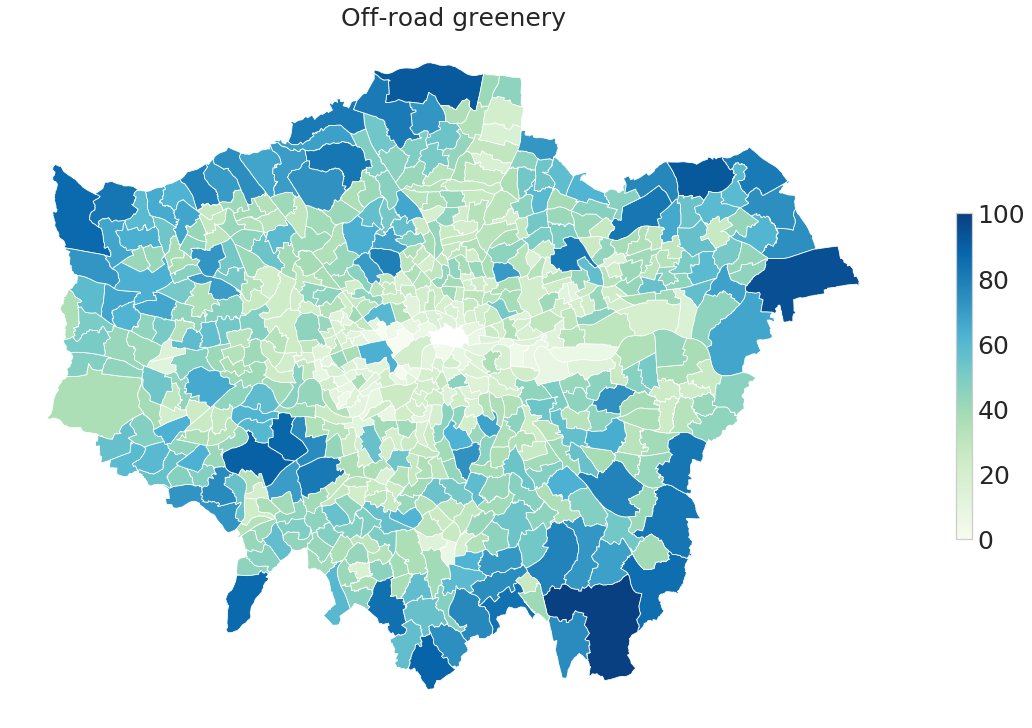

In [819]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Off-road greenery', fontdict={'fontsize': '25', 'fontweight' : '500'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=overall_green['sat_all_ward_green_scaled'].min(), vmax=overall_green['sat_all_ward_green_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(25)
overall_green.plot(ax=ax,column='sat_all_ward_green_scaled', cmap='GnBu', linewidth=0.8)

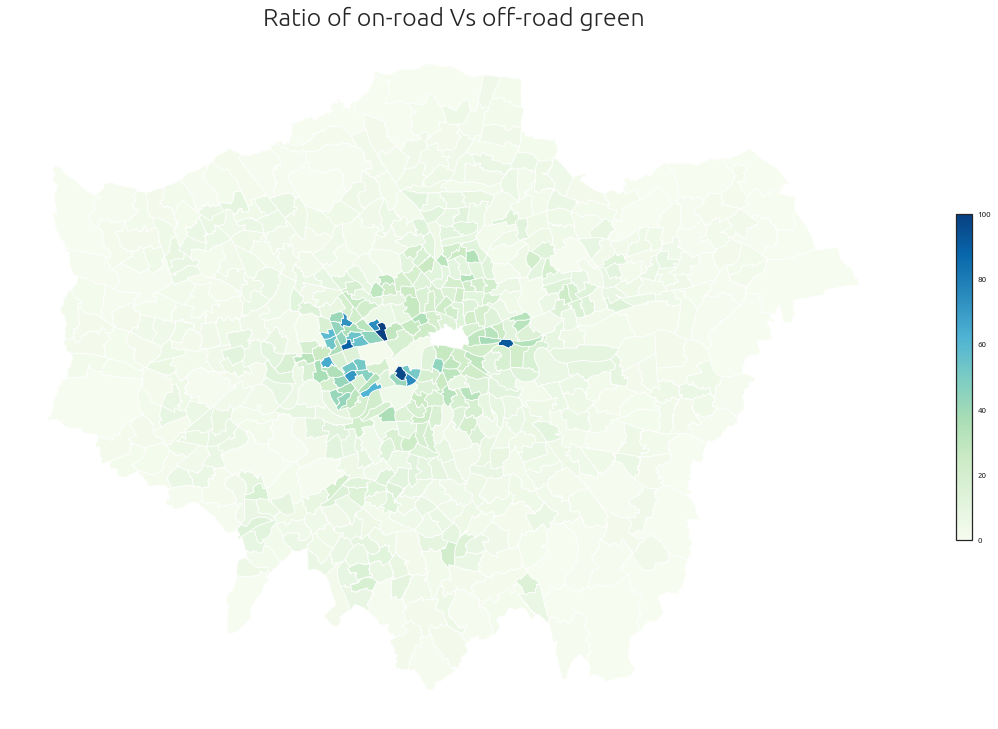

In [669]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Ratio of on-road Vs off-road green', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=overall_green['on_vs_off_green_ratio_scaled'].min(), vmax=overall_green['on_vs_off_green_ratio_scaled'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
overall_green.plot(ax=ax,column='on_vs_off_green_ratio_scaled', cmap='GnBu', linewidth=0.8)

In [670]:
data_merge = pd.merge(overall_green,selected_ward_data, left_on='GSS_CODE' , right_on='Ward Code')

In [671]:
data_merge.head(n=2)

GSS_CODE_x    NAME                                           geometry  \
0  E05000026   Abbey  POLYGON ((544735.197 184076.498, 544726.597 18...   
1  E05000027  Alibon  POLYGON ((547932.401 184916.597, 547944.801 18...   

   green_gsv  green_gsv_null  green_gsv_unweighted  mean_choice  \
0  10.524896       10.687261             10.687261    14.176203   
1  10.102674       10.269987             10.269987     9.614580   

   median_choice  std_choice  green_gsv_choice_median  ...  Income score  \
0      13.855123    5.704466                68.095426  ...         0.189   
1       8.563932    4.634217                70.179522  ...         0.215   

   Employment score  IDACI score  IDAOPI score  GSS_CODE_y  Median 2012/13  \
0             0.093        0.235         0.351   E05000026           33920   
1             0.137        0.257         0.275   E05000027           32470   

   depression_Prevalence  diabetes_Prevalence  \
0               2.536093             1.273696   
1               5.088617             1.926510   

   Population_per_square_kilometre  depression_Prescriptions  
0                     10916.340890              38378.697405  
1                      8110.947832              55226.760155  

[2 rows x 47 columns]

In [672]:
data_merge.corr()

green_gsv  green_gsv_null  \
green_gsv                         1.000000        0.991672   
green_gsv_null                    0.991672        1.000000   
green_gsv_unweighted              0.991672        1.000000   
mean_choice                      -0.237172       -0.245803   
median_choice                    -0.212617       -0.220552   
std_choice                       -0.243492       -0.248453   
green_gsv_choice_median           0.674826        0.669821   
area_sqkm                         0.315864        0.330958   
ward_green_contribution           1.000000        0.991672   
gsv_tree_score                    0.951655        0.961308   
green_gsv_scaled                  1.000000        0.991672   
green_gsv_unweighted_scaled       0.991672        1.000000   
green_gsv_null_scaled             0.991672        1.000000   
green_gsv_bland_average_scaled    0.951655        0.961308   
green_gsv_choice_median_scaled    0.674826        0.669821   
green_sat                         0.635846        0.627909   
green_sat_choice_median           0.649467        0.648273   
green_sat_null                   -0.040688       -0.030963   
green_sat_unweighted              0.815885        0.820719   
ward_sat_green_contribution       0.635846        0.627909   
ward_area                         0.315864        0.330958   
percent_on_road_sat_green_area    0.290193        0.284238   
percent_tot_sat_green             0.556400        0.572435   
sat_all_ward_green                0.511117        0.527421   
green_area                        0.396718        0.415985   
sat_ward_green_contribution       0.396718        0.415985   
on_vs_off_green_ratio            -0.130532       -0.137765   
on_vs_off_green_ratio_scaled     -0.130532       -0.137765   
sat_all_ward_green_scaled         0.511117        0.527421   
Population                       -0.171706       -0.166365   
Working age population           -0.251123       -0.249637   
IMD average score                -0.408515       -0.421623   
Income score                     -0.347890       -0.358559   
Employment score                 -0.265996       -0.277451   
IDACI score                      -0.325044       -0.332446   
IDAOPI score                     -0.422835       -0.434260   
Median 2012/13                    0.370699        0.371689   
depression_Prevalence             0.326776        0.328064   
diabetes_Prevalence              -0.260084       -0.257138   
Population_per_square_kilometre  -0.299173       -0.306966   
depression_Prescriptions          0.158294        0.163108   

                                 green_gsv_unweighted  mean_choice  \
green_gsv                                    0.991672    -0.237172   
green_gsv_null                               1.000000    -0.245803   
green_gsv_unweighted                         1.000000    -0.245803   
mean_choice                                 -0.245803     1.000000   
median_choice                               -0.220552     0.977598   
std_choice                                  -0.248453     0.901690   
green_gsv_choice_median                      0.669821     0.391219   
area_sqkm                                    0.330958    -0.407488   
ward_green_contribution                      0.991672    -0.237172   
gsv_tree_score                               0.961308    -0.245887   
green_gsv_scaled                             0.991672    -0.237172   
green_gsv_unweighted_scaled                  1.000000    -0.245803   
green_gsv_null_scaled                        1.000000    -0.245803   
green_gsv_bland_average_scaled               0.961308    -0.245887   
green_gsv_choice_median_scaled               0.669821     0.391219   
green_sat                                    0.627909     0.245565   
green_sat_choice_median                      0.648273     0.093324   
green_sat_null                              -0.030963     0.016551   
green_sat_unweighted                         0.820719    -0.257473   
ward_sat_green_contribution 

In [792]:
len(data_merge)

424

In [673]:
data_merge[['green_gsv', 'green_sat','sat_all_ward_green','Population_per_square_kilometre' ,'Median 2012/13']].corr()


green_gsv  green_sat  sat_all_ward_green  \
green_gsv                         1.000000   0.635846            0.511117   
green_sat                         0.635846   1.000000            0.193404   
sat_all_ward_green                0.511117   0.193404            1.000000   
Population_per_square_kilometre  -0.299173   0.133056           -0.715324   
Median 2012/13                    0.370699   0.409671            0.124655   

                                 Population_per_square_kilometre  \
green_gsv                                              -0.299173   
green_sat                                               0.133056   
sat_all_ward_green                                     -0.715324   
Population_per_square_kilometre                         1.000000   
Median 2012/13                                         -0.064552   

                                 Median 2012/13  
green_gsv                              0.370699  
green_sat                              0.409671  
sat_all_ward_green                     0.124655  
Population_per_square_kilometre       -0.064552  
Median 2012/13                         1.000000

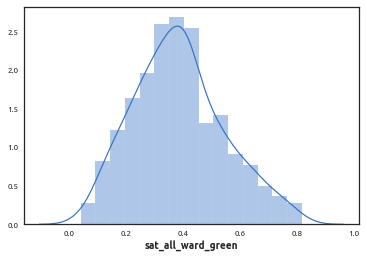

In [674]:
sns.distplot(data_merge['sat_all_ward_green'])

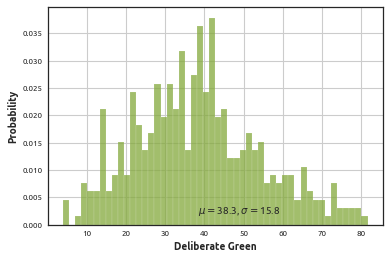

In [675]:
# the histogram of the data
data = data_merge['sat_all_ward_green']*100
n, bins, patches = plt.hist(data , 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Deliberate Green')
plt.ylabel('Probability')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.002, r'$\mu=$' + str(np.mean(data))[:4] + ', $\sigma=$' + str(np.std(data))[:4])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

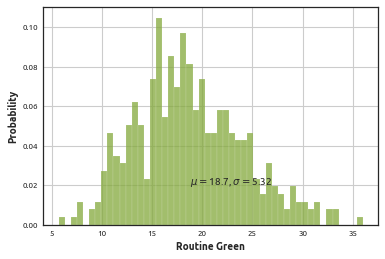

In [676]:
# the histogram of the data
data = data_merge['green_gsv']
n, bins, patches = plt.hist(data , 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Routine Green')
plt.ylabel('Probability')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.02, r'$\mu=$' + str(np.mean(data))[:4] + ', $\sigma=$' + str(np.std(data))[:4])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

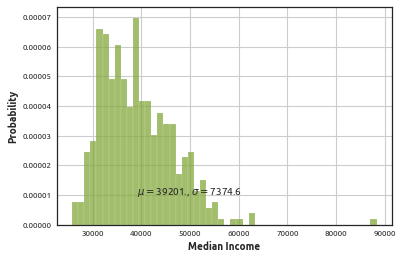

In [677]:
# the histogram of the data
data = data_merge['Median 2012/13']
n, bins, patches = plt.hist(data , 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Median Income')
plt.ylabel('Probability')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.00001, r'$\mu=$' + str(np.mean(data))[:6] + ', $\sigma=$' + str(np.std(data))[:6])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

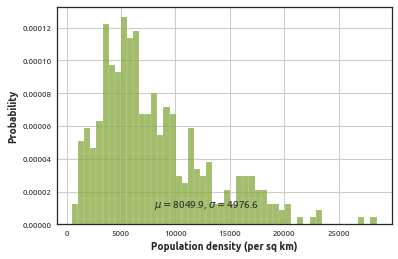

In [678]:
# the histogram of the data
data = data_merge['Population_per_square_kilometre']
n, bins, patches = plt.hist(data , 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Population density (per sq km)')
plt.ylabel('Probability')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.00001, r'$\mu=$' + str(np.mean(data))[:6] + ', $\sigma=$' + str(np.std(data))[:6])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

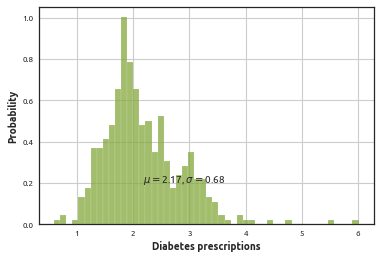

In [679]:
# the histogram of the data
data = data_merge['diabetes_Prevalence']
n, bins, patches = plt.hist(data , 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Diabetes prescriptions')
plt.ylabel('Probability')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.2, r'$\mu=$' + str(np.mean(data))[:4] + ', $\sigma=$' + str(np.std(data))[:4])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

In [680]:
# sns.distplot(data_merge['log_on_vs_off'])

In [764]:
on_street_crimes = ['Drug Trafficking','Robbery of Personal Property', 'Other Sexual Offences','Bicycle Theft',
                    'Violent Disorder','Theft from Person','Soliciting for Prostitution','Going Equipped for Stealing', 'Handling Stolen Goods',]

off_street_crimes = ['Perverting Course of Justice','Forgery or Use of Drug Prescription','Other Forgery','Perjury','Possession of False Documents','Public Fear Alarm or Distress']

In [765]:
crime_stats = pd.read_csv('scratchpad/ward_level_crime.csv')
crime_stats.head(n=2)
print(list(crime_stats.columns))
columns = ['201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003']
crime_dict = {'WardCode':[] , 'Total_crime':[] , 'on_street_crime' : [] , 'off_street_crime': []}
for name, group in crime_stats.groupby('WardCode'):
#     if name=='E05000649':
#         continue
#         print(group[columns])
    crime_dict['WardCode'].append(name)
    tot = 1
    for c in columns:
        tot+=sum(group[c])
    crime_dict['Total_crime'].append(tot)
    off_subgroup = group[group['MinorText'].isin(off_street_crimes)]

    tot = 1
    for c in columns:
        tot+=sum(off_subgroup[c])
    crime_dict['off_street_crime'].append(tot)
    
    on_subgroup = group[group['MinorText'].isin(on_street_crimes)]
    tot = 1
    for c in columns:
        tot+=sum(on_subgroup[c])
    crime_dict['on_street_crime'].append(tot)
    
crime_df = pd.DataFrame.from_dict(crime_dict)

['MajorText', 'MinorText', 'WardName', 'WardCode', 'LookUp_BoroughName', '201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102']


In [775]:
crime_df.head(n=2)

WardCode  Total_crime  on_street_crime  off_street_crime
0  E05000026         3210              621               111
1  E05000027          946              100                38

In [766]:
crime_stats['MajorText'].unique()

array(['Arson and Criminal Damage', 'Burglary', 'Drug Offences',
       'Miscellaneous Crimes Against Society', 'Possession of Weapons',
       'Public Order Offences', 'Robbery', 'Sexual Offences', 'Theft',
       'Vehicle Offences', 'Violence Against the Person'], dtype=object)

In [767]:
crime_stats['MinorText'].unique()

array(['Arson', 'Criminal Damage', 'Burglary - Business and Community',
       'Burglary - Residential', 'Drug Trafficking',
       'Possession of Drugs', 'Dangerous Driving',
       'Disclosure, Obstruction, False or Misleading State',
       'Fraud or Forgery Associated with Driver Records',
       'Going Equipped for Stealing', 'Handling Stolen Goods',
       'Making, Supplying or Possessing Articles for use i',
       'Obscene Publications', 'Other Forgery',
       'Other Notifiable Offences', 'Perverting Course of Justice',
       'Possession of False Documents',
       'Profitting From or Concealing Proceeds of Crime',
       'Threat or Possession With Intent to Commit Crimina',
       'Possession of Article with Blade or Point',
       'Possession of Firearm with Intent',
       'Possession of Firearms Offences', 'Possession of Other Weapon',
       'Other Offences Against the State, or Public Order',
       'Public Fear Alarm or Distress',
       'Racially or Religiously Aggrav

In [768]:
# crime_df['log_total_crime'] = np.log(crime_df['Total_crime'])

In [769]:
# columns = ['201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003']
# on_street_crime_dict = {'WardCode':[] , 'Street_crime':[]}
# for name, group in crime_stats.groupby('WardCode'):
# #     if name=='E05000649':
# #         continue
#     subgroup = group[group['MinorText'].isin(off_street_crimes)]
#     on_street_crime_dict['WardCode'].append(name)
#     tot = 1
#     for c in columns:
#         tot+=sum(subgroup[c])
#     on_street_crime_dict['Street_crime'].append(tot)
# on_street_crime_df = pd.DataFrame.from_dict(on_street_crime_dict)

In [770]:
# on_street_crime_df['log_street_crime'] = np.log(on_street_crime_df['Street_crime'])

In [771]:
# sns.distplot(on_street_crime_df['log_street_crime'])

In [772]:
# sns.distplot(crime_df['log_total_crime'])

In [773]:
%store -r data_sub_age

In [774]:
data_sub_age

WD17CD    avg_age
0    E05000420  33.195192
1    E05000571  34.208704
2    E05000570  40.219281
3    E05000572  37.033810
4    E05000620  35.017963
..         ...        ...
419  E05000257  34.873376
420  E05000314  37.183053
421  E05000438  36.385775
422  E05000439  33.045786
423  E05000230  31.788763

[424 rows x 2 columns]

In [776]:
data_merge_1 = pd.merge(data_merge,crime_df,left_on='GSS_CODE_x',right_on='WardCode')
# data_merge_2 = pd.merge(data_merge_1,on_street_crime_df,left_on='GSS_CODE_x',right_on='WardCode')
data_merge_2 = pd.merge(data_merge_1,data_sub_age,left_on='GSS_CODE_x',right_on='WD17CD')

data_merge_2['Crime_per_capita'] = np.log((data_merge_2['Total_crime']/data_merge_2['Population'])*1000)
data_merge_2['Crime_per_capita_flat'] = (data_merge_2['Total_crime']/data_merge_2['Population']) * 1000

data_merge_2['street_crime_per_capita'] = np.log((data_merge_2['on_street_crime']/data_merge_2['Population'])*1000)
data_merge_2['street_crime_per_capita_flat'] = (data_merge_2['on_street_crime']/data_merge_2['Population'])*1000


data_merge_2['off_street_crime_per_capita'] = np.log((data_merge_2['off_street_crime']/data_merge_2['Population'])*1000)
data_merge_2['off_street_crime_per_capita_flat'] = (data_merge_2['off_street_crime']/data_merge_2['Population'])*1000


data_merge_2['log_median_income'] = np.log(data_merge_2['Median 2012/13'])
data_merge_2['log_pop_density'] = np.log(data_merge_2['Population_per_square_kilometre'])


In [777]:
data_merge_2.columns

Index(['GSS_CODE_x', 'NAME', 'geometry', 'green_gsv', 'green_gsv_null',
       'green_gsv_unweighted', 'mean_choice', 'median_choice', 'std_choice',
       'green_gsv_choice_median', 'area_sqkm', 'ward_green_contribution',
       'gsv_tree_score', 'green_gsv_scaled', 'green_gsv_unweighted_scaled',
       'green_gsv_null_scaled', 'green_gsv_bland_average_scaled',
       'green_gsv_choice_median_scaled', 'green_sat',
       'green_sat_choice_median', 'green_sat_null', 'green_sat_unweighted',
       'ward_sat_green_contribution', 'ward_code', 'ward_area',
       'percent_on_road_sat_green_area', 'percent_tot_sat_green',
       'sat_all_ward_green', 'green_area', 'sat_ward_green_contribution',
       'on_vs_off_green_ratio', 'on_vs_off_green_ratio_scaled',
       'sat_all_ward_green_scaled', 'Ward Code', 'Population',
       'Working age population', 'IMD average score', 'Income score',
       'Employment score', 'IDACI score', 'IDAOPI score', 'GSS_CODE_y',
       'Median 2012/13', 'depres

In [778]:
len(data_merge_2)

424

In [781]:
dims = ['GSS_CODE_x','green_gsv','sat_all_ward_green','Population_per_square_kilometre','log_median_income' ,'Crime_per_capita' , 'street_crime_per_capita', 'Crime_per_capita_flat' , 'street_crime_per_capita_flat','off_street_crime_per_capita' , 'off_street_crime_per_capita_flat','diabetes_Prevalence','median_choice','avg_age']
export_feats = data_merge_2[dims].copy()
export_feats['sat_all_ward_green'] = export_feats['sat_all_ward_green']*100.0
export_feats.rename(columns={'GSS_CODE_x':'Ward Code', 'green_gsv':'Routine green' , 'sat_all_ward_green': 'Deliberate green'  , 'Population_per_square_kilometre' : 'Population density', 
                              'Crime_per_capita':'log_crime_per_capita' ,'Crime_per_capita_flat':'crime_per_capita' ,'street_crime_per_capita' : 'log_street_crime_per_capita' ,'street_crime_per_capita_flat':'street_crime_per_capita' , 
                              'off_street_crime_per_capita':'log_off_street_crime_per_capita' , 'off_street_crime_per_capita_flat':'off_street_crime_per_capita' ,  'diabetes_Prevalence' : 'diabetes_score_per_1000'},inplace=True)
export_feats.to_csv('scratchpad/VitaminN_features_v2.csv')

In [782]:
export_feats.head(n=10)

Ward Code  Routine green  Deliberate green  Population density  \
0  E05000026      10.524896         24.220831        10916.340890   
1  E05000027      10.102674         41.590789         8110.947832   
2  E05000028      10.891959         30.145544        11262.461060   
3  E05000029      16.489458         59.751525         3100.295858   
4  E05000030       9.190002         54.382518         3142.443544   
5  E05000031      14.827178         36.116956         8338.408304   
6  E05000032      14.809240         22.204107        12198.412700   
7  E05000033       9.536441         38.401162         9443.750000   
8  E05000034      14.278690         46.753841         5833.416459   
9  E05000035      15.805656         40.241872         7303.048780   

   log_median_income  log_crime_per_capita  log_street_crime_per_capita  \
0          10.431760              5.408884                     3.766188   
1          10.388072              4.468538                     2.221466   
2          10.404263              4.420536                     1.966401   
3          10.431760              4.604248                     2.297966   
4          10.529426              4.421085                     2.145669   
5          10.400316              4.479901                     1.828104   
6          10.291467              4.708173                     2.275692   
7          10.411810              4.461463                     2.288815   
8          10.352651              4.670976                     2.429300   
9          10.610784              4.339246                     2.228769   

   crime_per_capita  street_crime_per_capita  log_off_street_crime_per_capita  \
0        223.382046                43.215031                         2.044388   
1         87.229138                 9.220839                         1.253882   
2         83.140878                 7.144919                         1.221429   
3         99.907834                 9.953917                         1.547661   
4         83.186465                 8.547762                         1.208545   
5         88.225909                 6.222080                         1.531839   
6        110.849427                 9.734652                         1.038929   
7         86.614173                 9.863241                         1.173253   
8        106.801961                11.350933                         1.673632   
9         76.649705                 9.288426                         0.917824   

   off_street_crime_per_capita  diabetes_score_per_1000  median_choice  \
0                     7.724426                 1.273696      13.855123   
1                     3.503919                 1.926510       8.563932   
2                     3.392032                 1.773541      13.285051   
3                     4.700461                 1.900499       9.297543   
4                     3.348608                 2.102344       7.007301   
5                     4.626675                 2.109692       9.967131   
6                     2.826189                 1.332273      10.914299   
7                     3.232491                 2.188651      11.190105   
8                     5.331499                 1.935582       7.897403   
9                     2.503837                 2.038186      10.897008   

     avg_age  
0  29.572999  
1  33.568004  
2  32.032693  
3  36.004793  
4  37.247444  
5  32.669432  
6  28.668001  
7  33.878077  
8  34.456789  
9  34.270737

3.48783475291557 7.752428577053391 4.480073629117099 4.545233213480829 0.4678438252032605


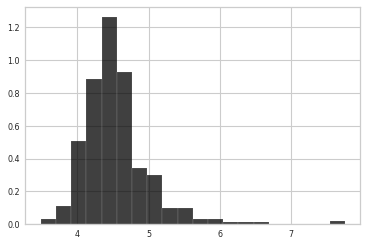

In [783]:
# the histogram of the data
data = data_merge_2['Crime_per_capita']
n, bins, patches = plt.hist(data , 20, density=True, facecolor='black', alpha=0.75)
print(np.min(data), np.max(data) ,  np.median(data), np.mean(data), np.std(data))
plt.grid(True)
plt.show()

In [784]:
data_merge_2[data_merge_2['Total_crime']==27524]

GSS_CODE_x      NAME                                           geometry  \
423  E05000649  West End  POLYGON ((528386.700 179725.603, 528381.102 17...   

     green_gsv  green_gsv_null  green_gsv_unweighted  mean_choice  \
423   5.672061        5.926372              5.926372    24.723696   

     median_choice  std_choice  green_gsv_choice_median  ...     WD17CD  \
423      23.729095   12.616452                37.089559  ...  E05000649   

      avg_age  Crime_per_capita  Crime_per_capita_flat  \
423  39.58823          7.752429            2327.217384   

     street_crime_per_capita  street_crime_per_capita_flat  \
423                 6.676376                    793.438742   

     off_street_crime_per_capita  off_street_crime_per_capita_flat  \
423                     3.686594                         39.908684   

     log_median_income  log_pop_density  
423          10.914543         8.713363  

[1 rows x 61 columns]

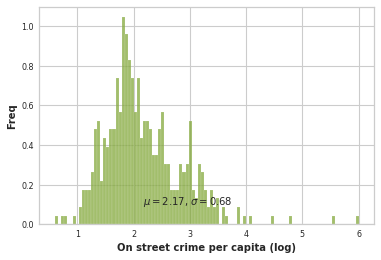

In [785]:
# the histogram of the data
data = data_merge_2['diabetes_Prevalence']
n, bins, patches = plt.hist(data , 100, density=True, facecolor='g', alpha=0.75)


plt.xlabel('On street crime per capita (log)')
plt.ylabel('Freq')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.1, r'$\mu=$' + str(np.mean(data))[:4] + ', $\sigma=$' + str(np.std(data))[:4])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

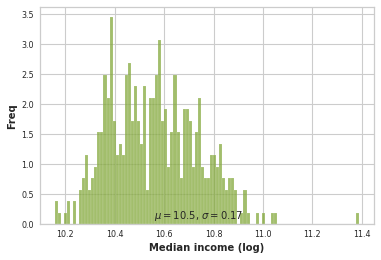

In [786]:
# the histogram of the data
data = data_merge_2['log_median_income']
n, bins, patches = plt.hist(data , 100, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Median income (log)')
plt.ylabel('Freq')
# plt.title('Histogram of IQ')
plt.text(np.mean(data), 0.1, r'$\mu=$' + str(np.mean(data))[:4] + ', $\sigma=$' + str(np.std(data))[:4])
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

In [788]:
data_merge_2[['green_gsv','gsv_tree_score','green_sat','sat_all_ward_green', 'on_vs_off_green_ratio','diabetes_Prevalence','Crime_per_capita','street_crime_per_capita','off_street_crime_per_capita']].corr()

green_gsv  gsv_tree_score  green_sat  \
green_gsv                     1.000000        0.951655   0.635846   
gsv_tree_score                0.951655        1.000000   0.632245   
green_sat                     0.635846        0.632245   1.000000   
sat_all_ward_green            0.511117        0.537785   0.193404   
on_vs_off_green_ratio        -0.130532       -0.165993   0.094730   
diabetes_Prevalence          -0.260084       -0.260717  -0.324956   
Crime_per_capita             -0.364059       -0.390775  -0.137649   
street_crime_per_capita      -0.359568       -0.378902   0.037958   
off_street_crime_per_capita  -0.293516       -0.316445  -0.151993   

                             sat_all_ward_green  on_vs_off_green_ratio  \
green_gsv                              0.511117              -0.130532   
gsv_tree_score                         0.537785              -0.165993   
green_sat                              0.193404               0.094730   
sat_all_ward_green                     1.000000              -0.624630   
on_vs_off_green_ratio                 -0.624630               1.000000   
diabetes_Prevalence                    0.046846              -0.213229   
Crime_per_capita                      -0.462888               0.278276   
street_crime_per_capita               -0.555778               0.407444   
off_street_crime_per_capita           -0.428231               0.304162   

                             diabetes_Prevalence  Crime_per_capita  \
green_gsv                              -0.260084         -0.364059   
gsv_tree_score                         -0.260717         -0.390775   
green_sat                              -0.324956         -0.137649   
sat_all_ward_green                      0.046846         -0.462888   
on_vs_off_green_ratio                  -0.213229          0.278276   
diabetes_Prevalence                     1.000000         -0.090678   
Crime_per_capita                       -0.090678          1.000000   
street_crime_per_capita                -0.154222          0.896348   
off_street_crime_per_capita            -0.114094          0.873647   

                             street_crime_per_capita  \
green_gsv                                  -0.359568   
gsv_tree_score                             -0.378902   
green_sat                                   0.037958   
sat_all_ward_green                         -0.555778   
on_vs_off_green_ratio                       0.407444   
diabetes_Prevalence                        -0.154222   
Crime_per_capita                            0.896348   
street_crime_per_capita                     1.000000   
off_street_crime_per_capita                 0.762353   

                             off_street_crime_per_capita  
green_gsv                                      -0.293516  
gsv_tree_score                                 -0.316445  
green_sat                                      -0.151993  
sat_all_ward_green                             -0.428231  
on_vs_off_green_ratio                           0.304162  
diabetes_Prevalence                            -0.114094  
Crime_per_capita                                0.873647  
street_crime_per_capita                         0.762353  
off_street_crime_per_capita                     1.000000

In [789]:
data_merge_2.columns

Index(['GSS_CODE_x', 'NAME', 'geometry', 'green_gsv', 'green_gsv_null',
       'green_gsv_unweighted', 'mean_choice', 'median_choice', 'std_choice',
       'green_gsv_choice_median', 'area_sqkm', 'ward_green_contribution',
       'gsv_tree_score', 'green_gsv_scaled', 'green_gsv_unweighted_scaled',
       'green_gsv_null_scaled', 'green_gsv_bland_average_scaled',
       'green_gsv_choice_median_scaled', 'green_sat',
       'green_sat_choice_median', 'green_sat_null', 'green_sat_unweighted',
       'ward_sat_green_contribution', 'ward_code', 'ward_area',
       'percent_on_road_sat_green_area', 'percent_tot_sat_green',
       'sat_all_ward_green', 'green_area', 'sat_ward_green_contribution',
       'on_vs_off_green_ratio', 'on_vs_off_green_ratio_scaled',
       'sat_all_ward_green_scaled', 'Ward Code', 'Population',
       'Working age population', 'IMD average score', 'Income score',
       'Employment score', 'IDACI score', 'IDAOPI score', 'GSS_CODE_y',
       'Median 2012/13', 'depres

In [790]:
data_merge_2.to_csv('scratchpad/joined_vitaminN_data.csv')

In [704]:
features_ztransform = ['Crime_per_capita','Street_crime_per_capita','green_gsv','gsv_tree_score','green_gsv_choice_median','mean_choice','median_choice','green_sat','green_sat_choice_median','sat_all_ward_green','Population_per_square_kilometre','IMD average score',
                       'Median 2012/13','diabetes_Prevalence','on_vs_off_green_ratio','log_median_income','log_pop_density' , 'avg_age']
data_analysis = data_merge_2[features_ztransform].copy()
for k in features_ztransform:
    data_analysis[k] = (data_analysis[k] - data_analysis[k].mean())/data_analysis[k].std(ddof=0)

In [705]:
data_analysis['on_road_bins'] = pd.qcut(data_analysis['green_gsv'],10)

In [706]:
cats , bins= pd.qcut(x=(data_merge_2['green_gsv']), q=10, retbins=True)
print(bins)
routine_bins_labels = []
for b in range(len(bins) -1 ):
    label = str(bins[b])[:4] + ' - ' + str(bins[b+1])[:3]
    routine_bins_labels.append(label)
print(routine_bins_labels)

[ 5.67206052 12.18588685 14.05606561 15.74171303 17.03841178 18.20157297
 19.5991737  21.33797452 23.20010408 25.97323082 36.02006354]
['5.67 - 12.', '12.1 - 14.', '14.0 - 15.', '15.7 - 17.', '17.0 - 18.', '18.2 - 19.', '19.5 - 21.', '21.3 - 23.', '23.2 - 25.', '25.9 - 36.']


In [707]:
data_analysis['off_road_bins'] = pd.qcut(data_analysis['sat_all_ward_green'],10)

In [708]:
data_analysis['age_bins'] = pd.qcut(data_analysis['avg_age'],10)

In [709]:
cats , bins= pd.qcut(x=(data_merge_2['sat_all_ward_green_scaled']), q=10, retbins=True)
print(bins)
offTrack_bins_labels = []
for b in range(len(bins) -1 ):
    label = str(bins[b])[:4] + ' - ' + str(bins[b+1])[:3]
    offTrack_bins_labels.append(label)
print(offTrack_bins_labels)

[ 0.         17.08429236 23.80947298 30.07577068 35.1447626  40.16352451
 43.85990368 47.79808278 56.11411985 66.75860252 91.43305719]
['0.0 - 17.', '17.0 - 23.', '23.8 - 30.', '30.0 - 35.', '35.1 - 40.', '40.1 - 43.', '43.8 - 47.', '47.7 - 56.', '56.1 - 66.', '66.7 - 91.']


In [710]:
data_analysis['income_bin'] = pd.qcut(data_analysis['log_median_income'],10)

In [711]:
data_analysis['density_bin'] = pd.qcut(data_analysis['log_pop_density'],10)

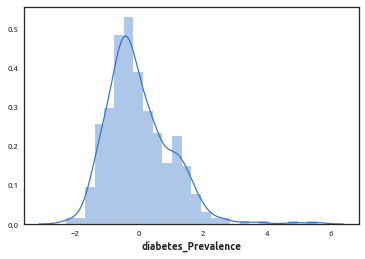

In [712]:
sns.distplot(data_analysis['diabetes_Prevalence'])

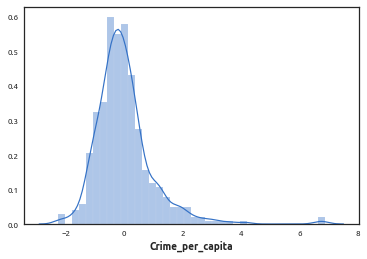

In [713]:
sns.distplot(data_analysis['Crime_per_capita'])

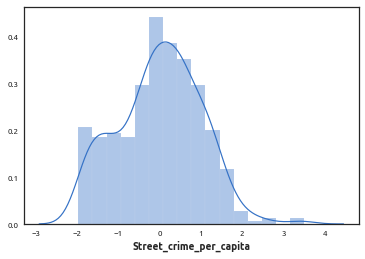

In [714]:
sns.distplot(data_analysis['Street_crime_per_capita'])

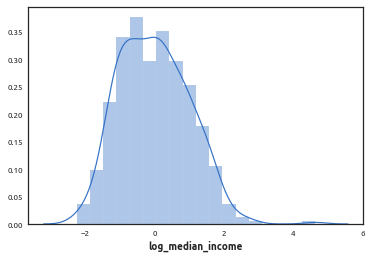

In [715]:
sns.distplot(data_analysis['log_median_income'])

In [716]:
road_stats = {}
for name , group in data_analysis.groupby('on_road_bins'):
    road_stats[name] = {}
    road_stats[name]['diabetes_prevalence'] = np.mean(group['diabetes_Prevalence'])
    road_stats[name]['diabetes_error'] = np.std(group['diabetes_Prevalence'])/np.sqrt(len(group))
    road_stats[name]['crime_per_capita'] = np.mean(group['Crime_per_capita'])
    road_stats[name]['crime_error'] = np.std(group['Crime_per_capita'])/np.sqrt(len(group))
    road_stats[name]['street_crime_per_capita'] = np.mean(group['Street_crime_per_capita'])
    road_stats[name]['street_crime_error'] = np.std(group['Street_crime_per_capita'])/np.sqrt(len(group))

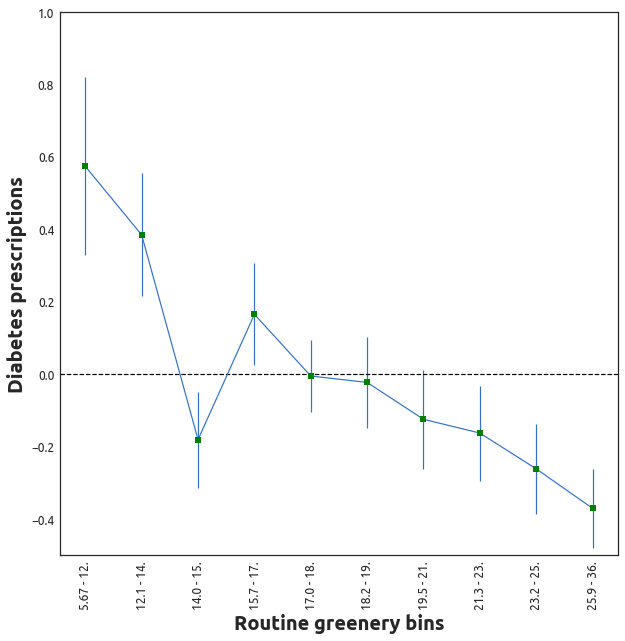

In [717]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['diabetes_prevalence'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['diabetes_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-.5, 1.0)
ax.axhline(0.0, ls='--',color='black')
plt.xticks( x , routine_bins_labels ,fontsize=12 , rotation = 90)
plt.yticks(fontsize=12)
plt.xlabel('Routine greenery bins' , fontsize = 20)
plt.ylabel('Diabetes prescriptions',fontsize = 20)
plt.show()

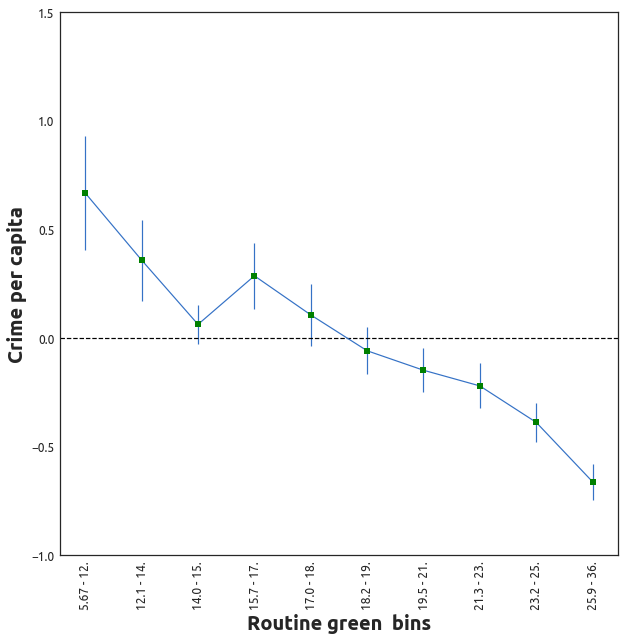

In [718]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks( x , routine_bins_labels ,fontsize=12 , rotation = 90)
plt.yticks(fontsize=12)
plt.xlabel('Routine green  bins' , fontsize = 20)
plt.ylabel('Crime per capita',fontsize = 20)
plt.show()

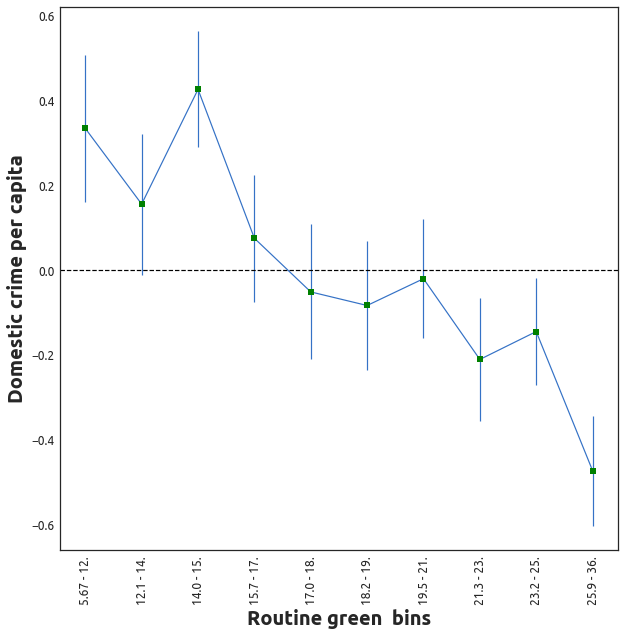

In [719]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['street_crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['street_crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
# plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks( x , routine_bins_labels ,fontsize=12 , rotation = 90)
plt.yticks(fontsize=12)
plt.xlabel('Routine green  bins' , fontsize = 20)
plt.ylabel('Domestic crime per capita',fontsize = 20)
plt.show()

In [720]:
road_stats = {}
for name , group in data_analysis.groupby('off_road_bins'):
    road_stats[name] = {}
    road_stats[name]['diabetes_prevalence'] = np.mean(group['diabetes_Prevalence'])
    road_stats[name]['diabetes_error'] = np.std(group['diabetes_Prevalence'])/np.sqrt(len(group))
    road_stats[name]['crime_per_capita'] = np.mean(group['Crime_per_capita'])
    road_stats[name]['crime_error'] = np.std(group['Crime_per_capita'])/np.sqrt(len(group))
    road_stats[name]['street_crime_per_capita'] = np.mean(group['Street_crime_per_capita'])
    road_stats[name]['street_crime_error'] = np.std(group['Street_crime_per_capita'])/np.sqrt(len(group))

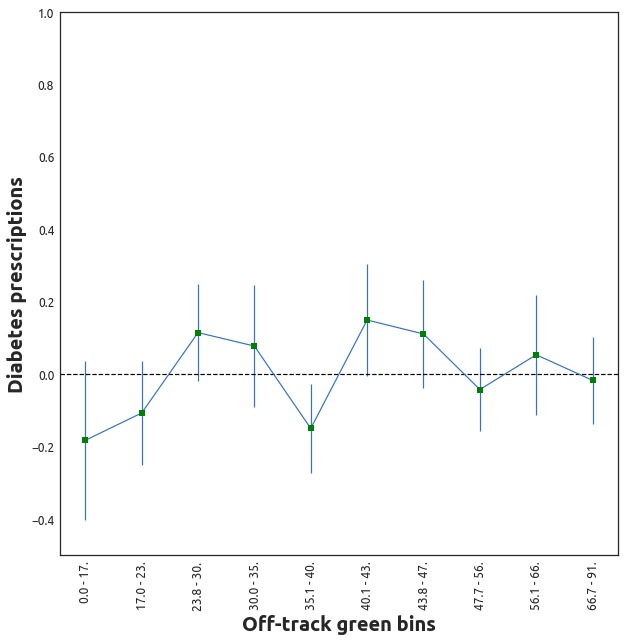

In [721]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['diabetes_prevalence'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['diabetes_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-.5, 1.0)
ax.axhline(0.0, ls='--',color='black')
plt.xticks( x , offTrack_bins_labels ,fontsize=12 , rotation = 90)
plt.yticks(fontsize=12)
plt.xlabel('Off-track green bins' , fontsize = 20)
plt.ylabel('Diabetes prescriptions',fontsize = 20)
plt.show()

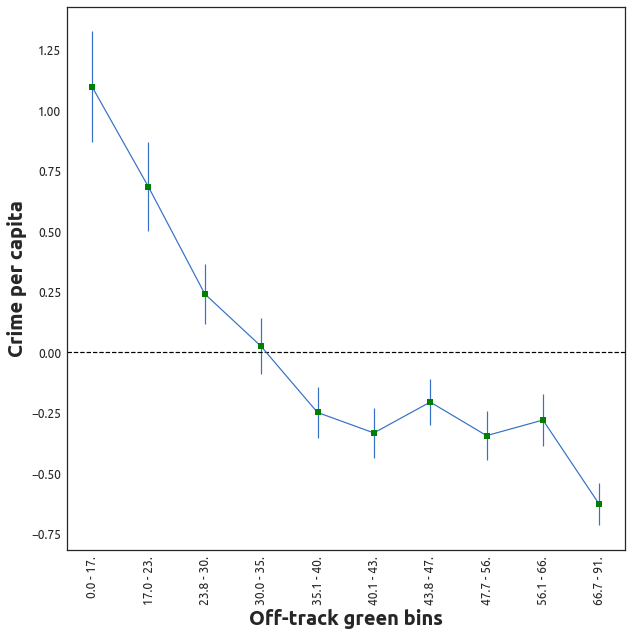

In [722]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
# plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks( x , offTrack_bins_labels ,fontsize=12 , rotation = 90)
plt.yticks(fontsize=12)
plt.xlabel('Off-track green bins' , fontsize = 20)
plt.ylabel('Crime per capita',fontsize = 20)
plt.show()

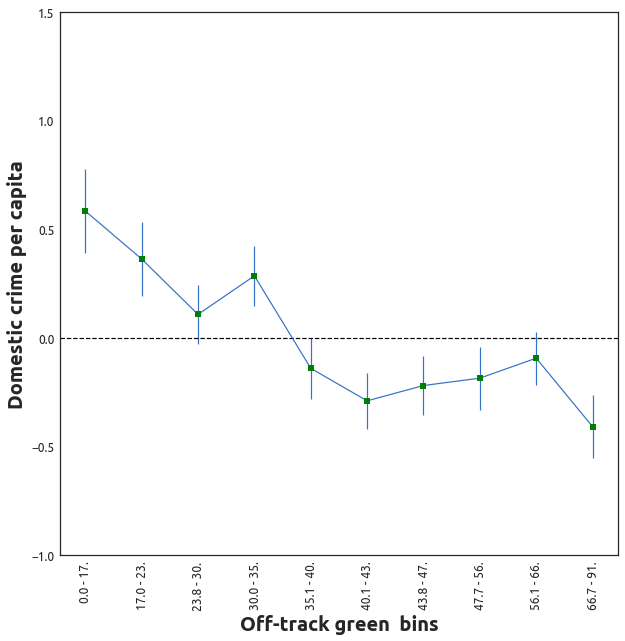

In [723]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['street_crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['street_crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks( x , offTrack_bins_labels ,fontsize=12 , rotation = 90)
plt.yticks(fontsize=12)
plt.xlabel('Off-track green  bins' , fontsize = 20)
plt.ylabel('Domestic crime per capita',fontsize = 20)
plt.show()

In [724]:
road_stats = {}
for name , group in data_analysis.groupby('income_bin'):
    road_stats[name] = {}
    road_stats[name]['diabetes_prevalence'] = np.mean(group['diabetes_Prevalence'])
    road_stats[name]['diabetes_error'] = np.std(group['diabetes_Prevalence'])/np.sqrt(len(group))
    road_stats[name]['crime_per_capita'] = np.mean(group['Crime_per_capita'])
    road_stats[name]['crime_error'] = np.std(group['Crime_per_capita'])/np.sqrt(len(group))
#     road_stats[name]['street_crime_per_capita'] = np.mean(group['Street_crime_per_capita'])
#     road_stats[name]['street_crime_error'] = np.std(group['Street_crime_per_capita'])/np.sqrt(len(group))

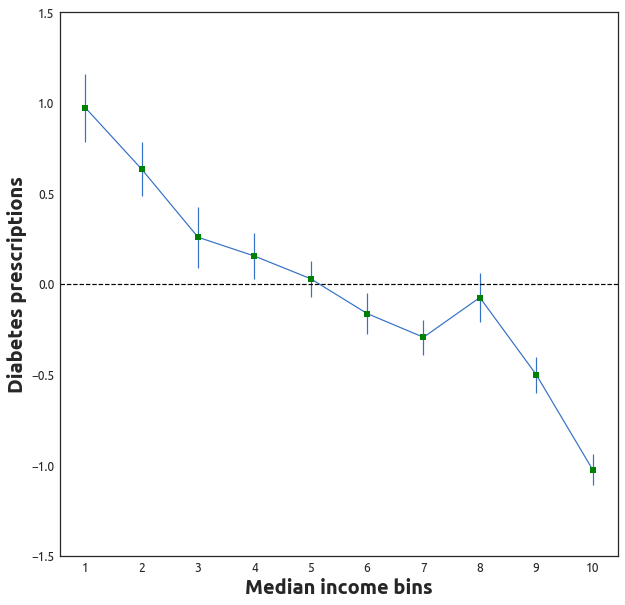

In [725]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['diabetes_prevalence'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['diabetes_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.5, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Median income bins' , fontsize = 20)
plt.ylabel('Diabetes prescriptions',fontsize = 20)
plt.show()

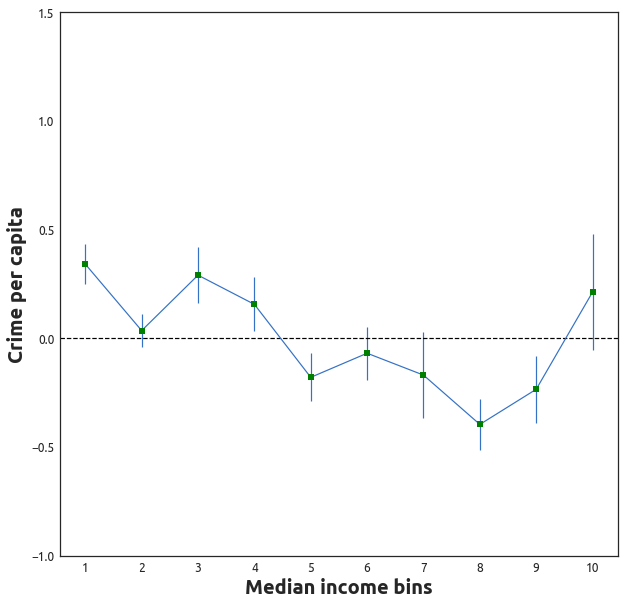

In [726]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Median income bins' , fontsize = 20)
plt.ylabel('Crime per capita',fontsize = 20)
plt.show()

In [727]:
road_stats = {}
for name , group in data_analysis.groupby('density_bin'):
    road_stats[name] = {}
    road_stats[name]['diabetes_prevalence'] = np.mean(group['diabetes_Prevalence'])
    road_stats[name]['diabetes_error'] = np.std(group['diabetes_Prevalence'])/np.sqrt(len(group))
    road_stats[name]['crime_per_capita'] = np.mean(group['Crime_per_capita'])
    road_stats[name]['crime_error'] = np.std(group['Crime_per_capita'])/np.sqrt(len(group))
#     road_stats[name]['street_crime_per_capita'] = np.mean(group['Street_crime_per_capita'])
#     road_stats[name]['street_crime_error'] = np.std(group['Street_crime_per_capita'])/np.sqrt(len(group))

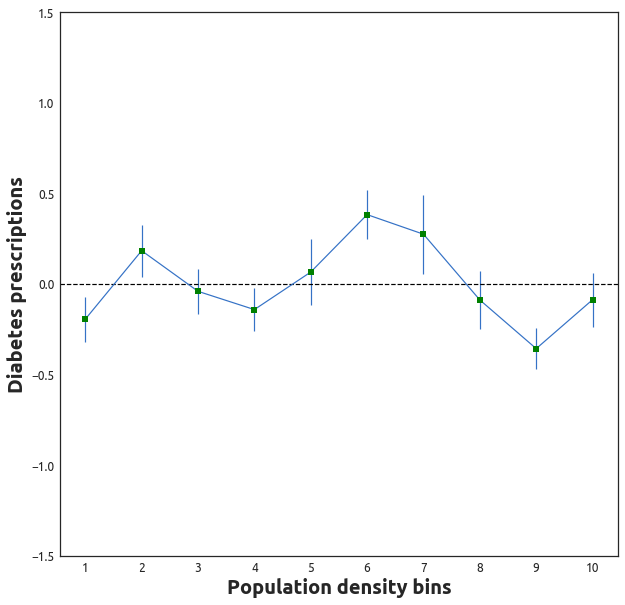

In [728]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['diabetes_prevalence'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['diabetes_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.5, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Population density bins' , fontsize = 20)
plt.ylabel('Diabetes prescriptions',fontsize = 20)
plt.show()

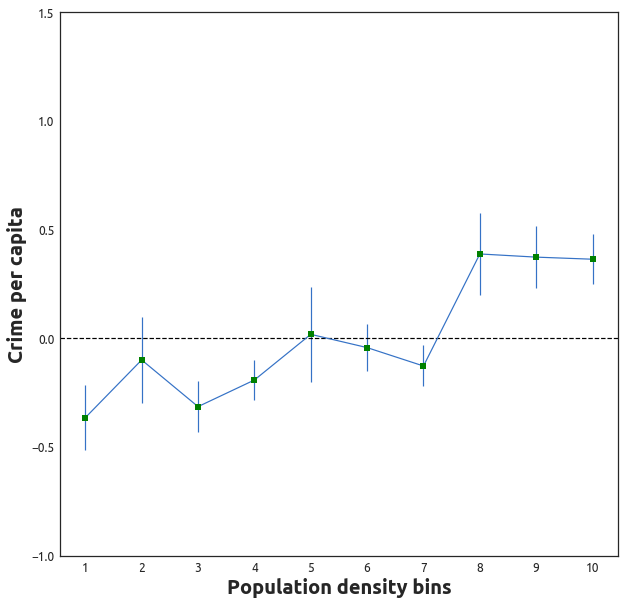

In [729]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Population density bins' , fontsize = 20)
plt.ylabel('Crime per capita',fontsize = 20)
plt.show()

In [730]:
road_stats = {}
for name , group in data_analysis.groupby('age_bins'):
    road_stats[name] = {}
    road_stats[name]['diabetes_prevalence'] = np.mean(group['diabetes_Prevalence'])
    road_stats[name]['diabetes_error'] = np.std(group['diabetes_Prevalence'])/np.sqrt(len(group))
    road_stats[name]['crime_per_capita'] = np.mean(group['Crime_per_capita'])
    road_stats[name]['crime_error'] = np.std(group['Crime_per_capita'])/np.sqrt(len(group))
#     road_stats[name]['street_crime_per_capita'] = np.mean(group['Street_crime_per_capita'])
#     road_stats[name]['street_crime_error'] = np.std(group['Street_crime_per_capita'])/np.sqrt(len(group))

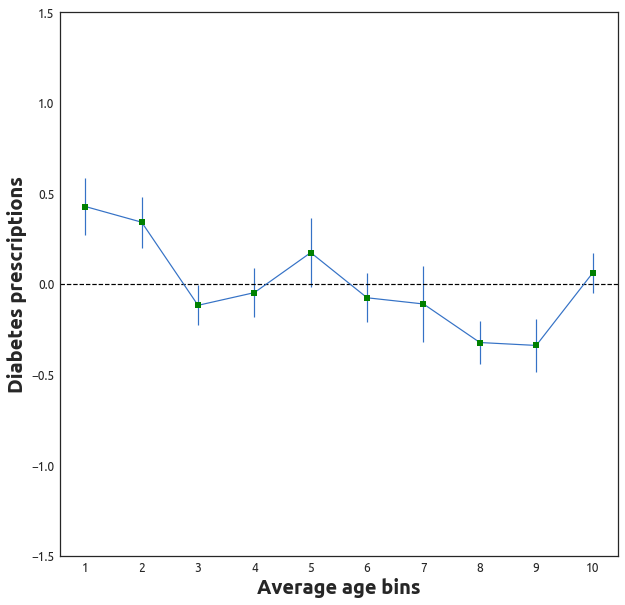

In [731]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['diabetes_prevalence'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['diabetes_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.5, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Average age bins' , fontsize = 20)
plt.ylabel('Diabetes prescriptions',fontsize = 20)
plt.show()

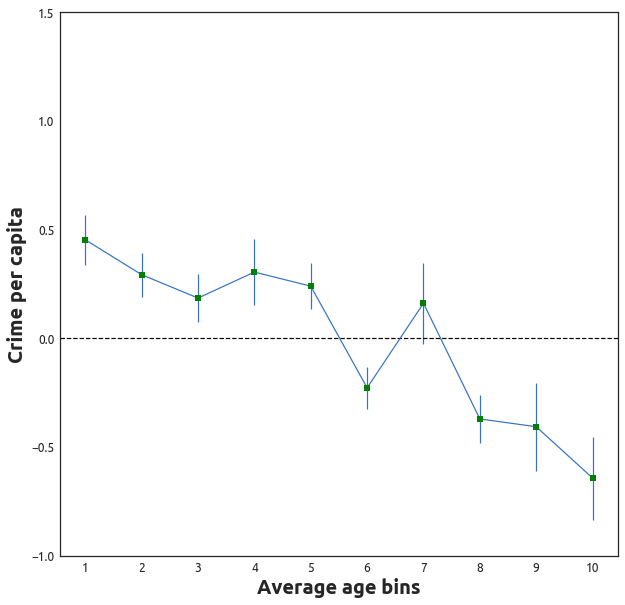

In [732]:
x = []
y = []
err = []
bin_count = 1
for k in road_stats:
    y.append(road_stats[k]['crime_per_capita'])
    x.append(str(bin_count))
    bin_count+=1
    err.append(road_stats[k]['crime_error'])
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.errorbar(x, y , yerr = err ,marker='s', mfc='red',
         mec='green', ms=2, mew=4)
plt.ylim(-1.0, 1.5)
ax.axhline(0.0, ls='--',color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Average age bins' , fontsize = 20)
plt.ylabel('Crime per capita',fontsize = 20)
plt.show()

In [733]:
data_analysis.head(n=2)

Crime_per_capita  Street_crime_per_capita  green_gsv  gsv_tree_score  \
0          1.846023                  0.06689  -1.541714       -1.677618   
1         -0.163932                  0.94320  -1.621022       -1.531545   

   green_gsv_choice_median  mean_choice  median_choice  green_sat  \
0                -1.122299     0.874106       0.891561  -0.738642   
1                -1.090930    -0.320829      -0.481390  -0.065899   

   green_sat_choice_median  sat_all_ward_green  ...  diabetes_Prevalence  \
0                -0.873651           -0.891571  ...            -1.308942   
1                 0.240532            0.201702  ...            -0.358528   

   on_vs_off_green_ratio  log_median_income  log_pop_density   avg_age  \
0              -0.130048          -0.715177         0.755258 -2.338784   
1              -0.448908          -0.958861         0.310890 -0.943806   

                   on_road_bins    off_road_bins  \
0  (-2.4539999999999997, -1.23]  (-0.895, -0.56]   
1  (-2.4539999999999997, -1.23]   (0.178, 0.389]   

                        age_bins        income_bin     density_bin  
0  (-2.6559999999999997, -1.192]  (-0.973, -0.645]  (0.547, 0.871]  
1               (-1.192, -0.877]  (-0.973, -0.645]  (0.304, 0.547]  

[2 rows x 23 columns]

In [734]:
data_analysis.columns

Index(['Crime_per_capita', 'Street_crime_per_capita', 'green_gsv',
       'gsv_tree_score', 'green_gsv_choice_median', 'mean_choice',
       'median_choice', 'green_sat', 'green_sat_choice_median',
       'sat_all_ward_green', 'Population_per_square_kilometre',
       'IMD average score', 'Median 2012/13', 'diabetes_Prevalence',
       'on_vs_off_green_ratio', 'log_median_income', 'log_pop_density',
       'avg_age', 'on_road_bins', 'off_road_bins', 'age_bins', 'income_bin',
       'density_bin'],
      dtype='object')

In [735]:
export_feats.head(n=2)

Ward Code  Routine green  Deliberate green  Population density  \
0  E05000026      10.524896         24.220831        10916.340890   
1  E05000027      10.102674         41.590789         8110.947832   

   log_median_income  log_crime_per_capita  log_street_crime_per_capita  \
0          10.431760              5.408884                     -1.56653   
1          10.388072              4.468538                     -0.99741   

   crime_per_capita  street_crime_per_capita  diabetes_score_per_1000  \
0        223.382046                 0.208768                 1.273696   
1         87.229138                 0.368834                 1.926510   

   median_choice    avg_age  
0      13.855123  29.572999  
1       8.563932  33.568004

[Text(0, 0.5, 'Routine UG'),
 Text(0, 1.5, 'Off-track UG'),
 Text(0, 2.5, 'Median income*'),
 Text(0, 3.5, 'Crime per capita*'),
 Text(0, 4.5, 'Diabetes prescriptions'),
 Text(0, 5.5, 'Population density*'),
 Text(0, 6.5, 'Average age')]

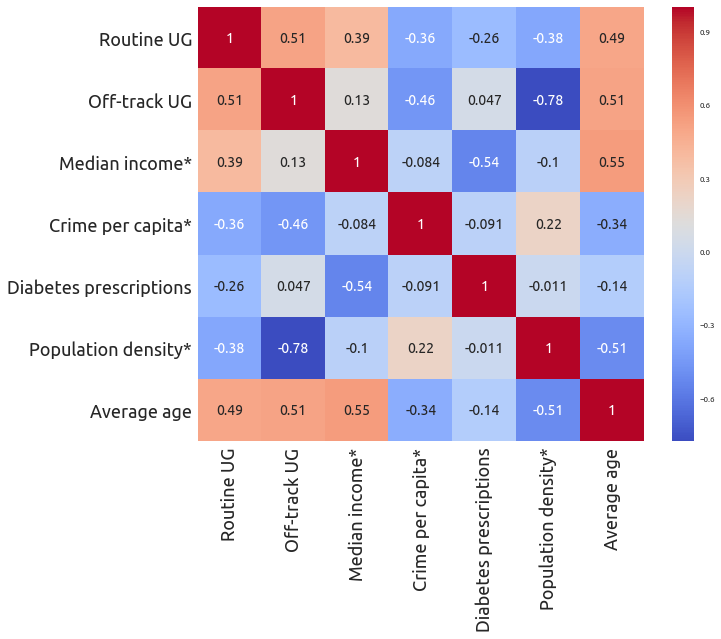

In [736]:
# dims = ['green_gsv','sat_all_ward_green','Population_per_square_kilometre','log_median_income' ,'Crime_per_capita' , 'Street_crime_per_capita' ,'diabetes_Prevalence','log_pop_density']
dims = ['green_gsv','sat_all_ward_green','log_median_income' ,'Crime_per_capita'  ,'diabetes_Prevalence','log_pop_density','avg_age']
feats = data_analysis[dims].copy()
# feats.rename(columns={'green_gsv':'Routine green' , 'sat_all_ward_green': 'Off track green'  , 'Population_per_square_kilometre' : 'Population density', 'log_pop_density' : 'Population density*',
#                       'log_median_income' : 'Median income*' , 'Crime_per_capita':'Crime per capita*' , 'Street_crime_per_capita':'Street crime per capita*' ,'diabetes_Prevalence' : 'Diabetes prescriptions'},inplace=True)
feats.rename(columns={'green_gsv':'Routine UG' , 'sat_all_ward_green': 'Off-track UG'  , 'log_pop_density' : 'Population density*',
                      'log_median_income' : 'Median income*' , 'Crime_per_capita':'Crime per capita*' , 'diabetes_Prevalence' : 'Diabetes prescriptions','avg_age':'Average age'},inplace=True)
fig, ax = plt.subplots(figsize=(10,8))         
corr = feats.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='coolwarm' , annot_kws={"fontsize":14}  )
ax.set_xticklabels(corr.columns, fontsize=18 , rotation = 90)
ax.set_yticklabels(corr.columns, fontsize=18, rotation = 0)

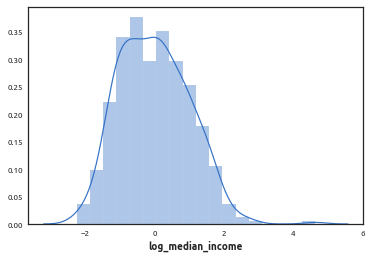

In [737]:
sns.distplot(data_analysis['log_median_income'])

In [738]:
import statsmodels.api as sm
from sklearn import preprocessing
base = ['log_pop_density' ,'log_median_income']
# base = ['IMD average score']
terms = []
interactions = [('sat_all_ward_green','Population_per_square_kilometre'),('sat_all_ward_green','log_pop_density'),('sat_all_ward_green','log_median_income') , 
                ('green_gsv','sat_all_ward_green') ,('green_gsv','Population_per_square_kilometre'), ('green_gsv','log_pop_density') ,('green_gsv','log_median_income'),('log_median_income','green_sat'),
               ('median_choice','Population_per_square_kilometre'),('median_choice','log_pop_density'),('median_choice','log_median_income'),
                ('median_choice','sat_all_ward_green') , ('median_choice','green_gsv')]
for index , i in enumerate(interactions):
    sampled = data_analysis[[i[0] , i[1]]]
    normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
    data_analysis[str(i[0])+'*'+str(i[1])] = normalized_sampled[i[0]] * normalized_sampled[i[1]]
    terms.append(str(i[0])+'*'+str(i[1]))

print (terms)
M1 = base + ['sat_all_ward_green'] + ['sat_all_ward_green*log_pop_density']
# M2 = base + ['green_sat','green_gsv'] + ['Population_per_square_kilometre*green_sat', 'Median 2012/13*green_sat'] +  ['green_gsv*Population_per_square_kilometre', 'green_gsv*Median 2012/13'] + ['green_gsv*green_sat']
M3 = base + ['sat_all_ward_green','green_gsv'] + ['sat_all_ward_green*log_pop_density'] +  ['green_gsv*log_pop_density', 'green_gsv*log_median_income'] + ['green_gsv*sat_all_ward_green']
# M4 = base + ['sat_all_ward_green','gsv_tree_score'] + ['sat_all_ward_green*Population_per_square_kilometre', 'sat_all_ward_green*Median 2012/13']  + ['gsv_tree_score*Population_per_square_kilometre' , 'gsv_tree_score*Median 2012/13'] + ['gsv_tree_score*sat_all_ward_green']
M5 = base + ['sat_all_ward_green','green_gsv','median_choice'] + ['sat_all_ward_green*log_pop_density'] +  ['green_gsv*log_pop_density', 'green_gsv*log_median_income'] + ['green_gsv*sat_all_ward_green'] + ['median_choice*log_pop_density', 'median_choice*sat_all_ward_green']
# M6 = base + ['sat_all_ward_green','green_gsv','on_vs_off_green_ratio'] + ['green_gsv*Population_per_square_kilometre' , 'green_gsv*Median 2012/13'] + ['sat_all_ward_green*Population_per_square_kilometre', 'sat_all_ward_green*Median 2012/13']  + ['green_gsv*sat_all_ward_green'] +['on_vs_off_green_ratio*Median 2012/13','on_vs_off_green_ratio*Population_per_square_kilometre'] + ['on_vs_off_green_ratio*green_gsv','on_vs_off_green_ratio*sat_all_ward_green']
# M6 = base + ['on_vs_off_green_ratio'] +['on_vs_off_green_ratio*Median 2012/13','on_vs_off_green_ratio*Population_per_square_kilometre']
# M6 = base + ['median_choice'] +['median_choice*Population_per_square_kilometre','median_choice*Median 2012/13']
M6 = base + ['sat_all_ward_green','green_gsv','median_choice','on_vs_off_green_ratio'] +['green_gsv*log_pop_density' , 'green_gsv*log_median_income'] + ['sat_all_ward_green*log_pop_density', 'sat_all_ward_green*log_median_income']  + ['green_gsv*sat_all_ward_green'] + ['median_choice*log_pop_density','median_choice*log_median_income'] + ['median_choice*green_gsv','median_choice*sat_all_ward_green'] + ['on_vs_off_green_ratio*log_median_income','on_vs_off_green_ratio*log_pop_density'] + ['on_vs_off_green_ratio*green_gsv','on_vs_off_green_ratio*sat_all_ward_green']



# outcome = ['Crime_per_capita']
outcome = ['diabetes_Prevalence']
    
    


['sat_all_ward_green*Population_per_square_kilometre', 'sat_all_ward_green*log_pop_density', 'sat_all_ward_green*log_median_income', 'green_gsv*sat_all_ward_green', 'green_gsv*Population_per_square_kilometre', 'green_gsv*log_pop_density', 'green_gsv*log_median_income', 'log_median_income*green_sat', 'median_choice*Population_per_square_kilometre', 'median_choice*log_pop_density', 'median_choice*log_median_income', 'median_choice*sat_all_ward_green', 'median_choice*green_gsv']


In [739]:
R2s = []

In [740]:
features = base
Y_dim = outcome
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
R2s.append(model_IMD.rsquared_adj)
model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

['log_pop_density', 'log_median_income']


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     diabetes_Prevalence   R-squared:                       0.296
Model:                             OLS   Adj. R-squared:                  0.293
Method:                  Least Squares   F-statistic:                     88.48
Date:                 Wed, 02 Jun 2021   Prob (F-statistic):           8.34e-33
Time:                         12:36:16   Log-Likelihood:                -527.24
No. Observations:                  424   AIC:                             1060.
Df Residuals:                      421   BIC:                             1073.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -3.502e-10      0.041  -8.56e-09      1.000      -0.080       0.080
log_pop_density      -0.0658      0.041     -1.601      0.110      -0.147       0.015
log_median_income    -0.5466      0.041    -13.300      0.000      -0.627      -0.466
==============================================================================
Omnibus:                      102.769   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.418
Skew:                           1.106   Prob(JB):                     4.36e-70
Kurtosis:                       6.631   Cond. No.                         1.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [741]:
features = M1
Y_dim = outcome
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
R2s.append(model_IMD.rsquared_adj)
model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

['log_pop_density', 'log_median_income', 'sat_all_ward_green', 'sat_all_ward_green*log_pop_density']


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     diabetes_Prevalence   R-squared:                       0.307
Model:                             OLS   Adj. R-squared:                  0.300
Method:                  Least Squares   F-statistic:                     46.41
Date:                 Wed, 02 Jun 2021   Prob (F-statistic):           2.78e-32
Time:                         12:36:16   Log-Likelihood:                -523.87
No. Observations:                  424   AIC:                             1058.
Df Residuals:                      419   BIC:                             1078.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -0.0766      0.253     -0.303      0.762      -0.573       0.420
log_pop_density                        0.0403      0.097      0.415      0.678      -0.150       0.231
log_median_income                     -0.5531      0.041    -13.330      0.000      -0.635      -0.472
sat_all_ward_green                     0.1318      0.130      1.014      0.311      -0.124       0.387
sat_all_ward_green*log_pop_density     0.2997      0.976      0.307      0.759      -1.618       2.217
==============================================================================
Omnibus:                      112.269   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.723
Skew:                           1.169   Prob(JB):                     1.43e-85
Kurtosis:                       7.081   Cond. No.                         33.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [742]:
# features = M2
# Y_dim = outcome
# Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
# X = np.array(data_analysis[features].values,dtype=np.float32)
# X = sm.add_constant(X)
# print(features)
# model_IMD = sm.OLS(Y, X).fit()
# R2s.append(model_IMD.rsquared_adj)
# model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

In [743]:
features = M3
Y_dim = outcome
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
R2s.append(model_IMD.rsquared_adj)
model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

['log_pop_density', 'log_median_income', 'sat_all_ward_green', 'green_gsv', 'sat_all_ward_green*log_pop_density', 'green_gsv*log_pop_density', 'green_gsv*log_median_income', 'green_gsv*sat_all_ward_green']


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     diabetes_Prevalence   R-squared:                       0.356
Model:                             OLS   Adj. R-squared:                  0.343
Method:                  Least Squares   F-statistic:                     28.63
Date:                 Wed, 02 Jun 2021   Prob (F-statistic):           1.77e-35
Time:                         12:36:16   Log-Likelihood:                -508.46
No. Observations:                  424   AIC:                             1035.
Df Residuals:                      415   BIC:                             1071.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -0.9065      0.887     -1.022      0.307      -2.650       0.837
log_pop_density                        0.1392      0.154      0.902      0.368      -0.164       0.443
log_median_income                     -0.8065      0.106     -7.589      0.000      -1.015      -0.598
sat_all_ward_green                    -0.1348      0.216     -0.624      0.533      -0.559       0.289
green_gsv                             -0.3081      0.373     -0.825      0.410      -1.042       0.426
sat_all_ward_green*log_pop_density     2.0492      1.254      1.635      0.103      -0.415       4.513
green_gsv*log_pop_density             -2.5658      2.268     -1.131      0.259      -7.023       1.892
green_gsv*log_median_income            4.9609      1.560      3.179      0.002       1.894       8.028
green_gsv*sat_all_ward_green           1.4841      1.711      0.867      0.386      -1.880       4.848
==============================================================================
Omnibus:                       62.529   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.106
Skew:                           0.743   Prob(JB):                     5.67e-34
Kurtosis:                       5.541   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [744]:
predict_y = model_IMD.predict(X)


In [745]:
pearsonr(predict_y,np.reshape(Y,424))

(0.596336061123315, 3.4764938492928974e-42)

In [746]:
# features = M4
# Y_dim = outcome
# Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
# X = np.array(data_analysis[features].values,dtype=np.float32)
# X = sm.add_constant(X)
# print(features)
# model_IMD = sm.OLS(Y, X).fit()
# R2s.append(model_IMD.rsquared_adj)
# model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

In [747]:
# features = M5
# Y_dim = outcome
# Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
# X = np.array(data_analysis[features].values,dtype=np.float32)
# X = sm.add_constant(X)
# print(features)
# model_IMD = sm.OLS(Y, X).fit()
# R2s.append(model_IMD.rsquared_adj)
# model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

In [748]:
R2s

[0.29260142436345016, 0.3004252914558013, 0.3431948498095233]

In [749]:
# features = M6
# Y_dim = outcome
# Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
# X = np.array(data_analysis[features].values,dtype=np.float32)
# X = sm.add_constant(X)
# print(features)
# model_IMD = sm.OLS(Y, X).fit()
# R2s.append(model_IMD.rsquared_adj)
# model_IMD.summary(xname=['intercept']+features, yname =  outcome[0])

In [750]:
pearsonr(data_merge_2['gsv_tree_score'],data_merge_2['green_gsv'])

(0.9516548680006602, 1.9226835160304658e-218)

In [751]:
pearsonr(data_merge_2['sat_all_ward_green'],data_merge_2['green_sat'])

(0.19340414622950977, 6.108266786831966e-05)

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), <a list of 6 Text yticklabel objects>)

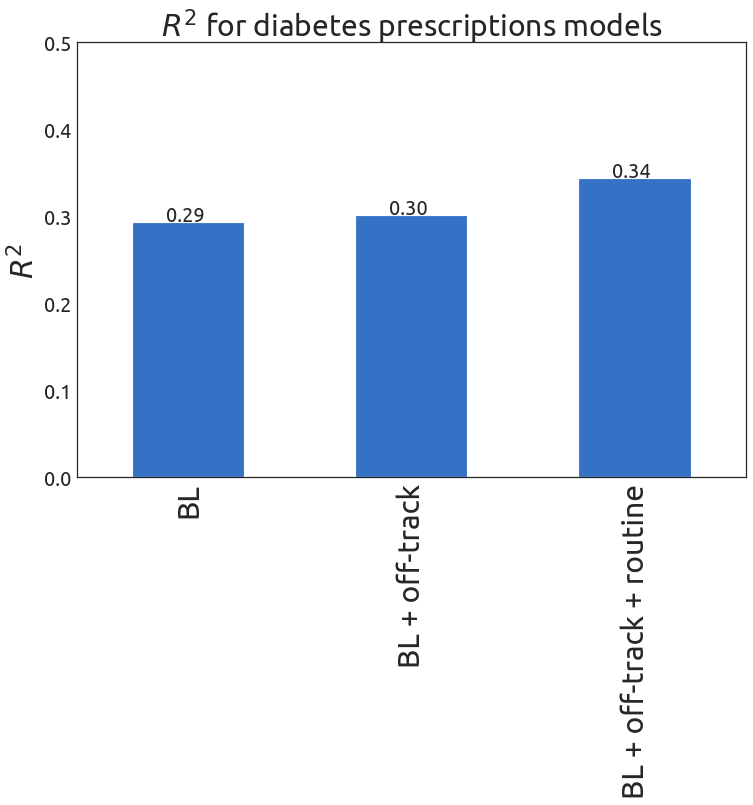

In [752]:
# Y = [0.657, 0.669 , 0.660 , 0.664 , 0.658 , 0.665]
Y = R2s
R2_series = pd.Series.from_array(Y)
X_labels = ['BL','BL + off-track', 'BL + off-track + routine', 'BL + Off + On + Choice' ]
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = R2_series.plot(kind='bar')
plt.grid(False)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() + 0.15 , p.get_height() * 1.005),fontsize = 20)
plt.ylim(0.0, 0.5)
# ax.set_title('$R^2$ for crime per capita models',fontsize=30)
ax.set_title('$R^2$ for diabetes prescriptions models',fontsize=30)
ax.set_ylabel('$R^2$',fontsize=30)
ax.set_xticklabels(X_labels,fontsize=30)
plt.yticks(fontsize=20)



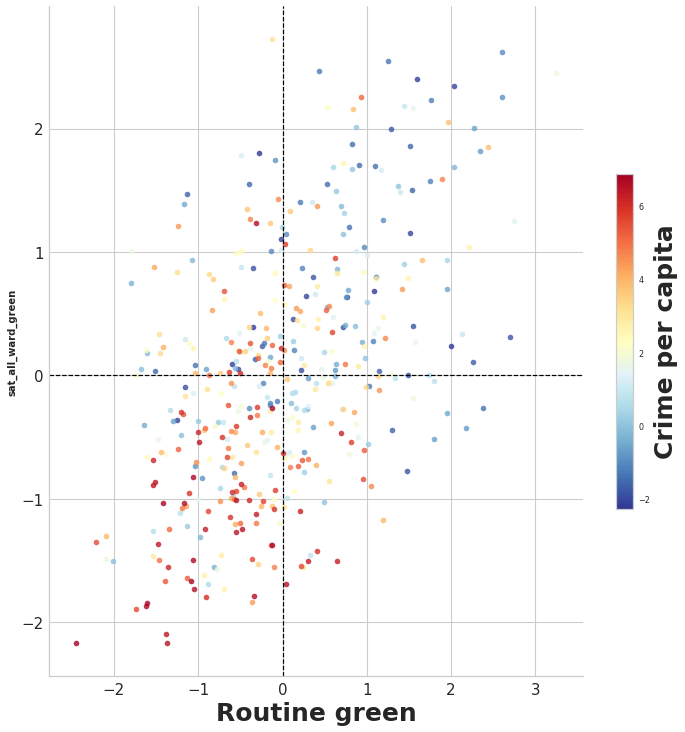

In [761]:
sns.set_style("whitegrid")
g= sns.lmplot( x='green_gsv', y='sat_all_ward_green', data=data_analysis, fit_reg=False, hue='Crime_per_capita', legend=False, palette="RdYlBu_r",height=10)
ax = g.axes[0][0]
scalarmap = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=max(data_analysis['Crime_per_capita']), vmax=min(data_analysis['Crime_per_capita'])))
cbar = plt.colorbar(scalarmap,shrink=0.5)
cbar.set_label('Crime per capita', fontsize = 25)

ax.axhline(0.0, ls='--',color='black')
ax.axvline(0.0, ls='--',color='black')
ax.set_xlabel("Routine green",fontsize=25)
# ax.set_ylabel("$rsl(a)$",fontsize=25)
ax.tick_params(labelsize=15)

In [754]:
np.arange(0.0,0.8,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [755]:
feats.head()

Routine UG  Off-track UG  Median income*  Crime per capita*  \
0   -1.541714     -0.891571       -0.715177           1.846023   
1   -1.621022      0.201702       -0.958861          -0.163932   
2   -1.472767     -0.518667       -0.868551          -0.266535   
3   -0.421366      1.344747       -0.715177           0.126142   
4   -1.792453      1.006819       -0.170419          -0.265363   

   Diabetes prescriptions  Population density*  Average age  
0               -1.308942             0.755258    -2.338784  
1               -0.358528             0.310890    -0.943806  
2               -0.581232             0.801953    -1.479907  
3               -0.396396            -1.127797    -0.092926  
4               -0.102537            -1.107597     0.340984

In [756]:
feats.to_csv('scratchpad/VitaminN_feats.csv')

In [757]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing

features = ['green_gsv', 'green_sat','sat_all_ward_green','Population_per_square_kilometre' ,'Median 2012/13']
Y_dim = ['IMD average score']
min_max_scaler = preprocessing.MinMaxScaler() 
Y = np.array(data_merge[Y_dim].values,dtype=np.float32)
X = np.array(data_merge[features].values,dtype=np.float32)

X = min_max_scaler.fit_transform(X)
Y = min_max_scaler.fit_transform(Y)

In [758]:
X = sm.add_constant(X)
print(features)
model_IMD = sm.OLS(Y, X).fit()
model_IMD.summary(xname=['intercept']+features, yname =  'IMD average score')

['green_gsv', 'green_sat', 'sat_all_ward_green', 'Population_per_square_kilometre', 'Median 2012/13']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      IMD average score   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     193.4
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          2.51e-106
Time:                        12:36:21   Log-Likelihood:                 312.12
No. Observations:                 424   AIC:                            -612.2
Df Residuals:                     418   BIC:                            -587.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept                           0.7092      0.031     23.033      0.000       0.649       0.770
green_gsv                          -0.2402      0.050     -4.788      0.000      -0.339      -0.142
green_sat                           0.3423      0.050      6.823      0.000       0.244       0.441
sat_all_ward_green                 -0.1403      0.045     -3.107      0.002      -0.229      -0.052
Population_per_square_kilometre     0.1125      0.051      2.205      0.028       0.012       0.213
Median 2012/13                     -1.3853      0.054    -25.774      0.000      -1.491      -1.280
==============================================================================
Omnibus:                       93.409   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.734
Skew:                           0.842   Prob(JB):                    1.64e-102
Kurtosis:                       7.868   Cond. No.                         16.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [759]:
# features = ['green_gsv', 'green_sat','sat_all_ward_green','Population_per_square_kilometre' ,'Median 2012/13']
# features = ['green_gsv', 'green_sat','Population_per_square_kilometre' ,'Median 2012/13']
# features = ['green_gsv', 'sat_all_ward_green' ,'Median 2012/13']
features = ['green_gsv', 'green_sat' ,'Median 2012/13']
Y_dim = ['IMD average score']

interactions = [('green_gsv','green_sat'),('green_gsv','Population_per_square_kilometre'),('Population_per_square_kilometre','green_sat'),('green_gsv','Median 2012/13'),('Median 2012/13','green_sat')]
terms = []
for index , i in enumerate(interactions):
    sampled = data_analysis[[i[0] , i[1]]]
    normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
    data_analysis[str(i[0])+'*'+str(i[1])] = normalized_sampled[i[0]] * normalized_sampled[i[1]]
    terms.append(str(i[0])+'*'+str(i[1]))

interaction_terms = terms

# features = features + interaction_terms


print(features)
min_max_scaler = preprocessing.MinMaxScaler() 
Y = np.array(data_analysis[Y_dim].values,dtype=np.float32)
X = np.array(data_analysis[features].values,dtype=np.float32)

# X = min_max_scaler.fit_transform(X)
# Y = min_max_scaler.fit_transform(Y)





['green_gsv', 'green_sat', 'Median 2012/13']


In [760]:
X = sm.add_constant(X)
print(features)
model_IMD_interaction = sm.OLS(Y, X).fit()
model_IMD_interaction.summary(xname=['intercept']+features, yname =  'IMD_z_score')

['green_gsv', 'green_sat', 'Median 2012/13']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMD_z_score   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     278.9
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           1.49e-99
Time:                        12:36:21   Log-Likelihood:                -369.29
No. Observations:                 424   AIC:                             746.6
Df Residuals:                     420   BIC:                             762.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -2.835e-10      0.028     -1e-08      1.000      -0.055       0.055
green_gsv         -0.3492      0.037     -9.437      0.000      -0.422      -0.276
green_sat          0.3590      0.038      9.529      0.000       0.285       0.433
Median 2012/13    -0.7757      0.031    -24.775      0.000      -0.837      -0.714
==============================================================================
Omnibus:                       45.645   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.837
Skew:                           0.502   Prob(JB):                     2.87e-28
Kurtosis:                       5.484   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""